# Fantasy Football Draft Analysis

Author: Melody Bass

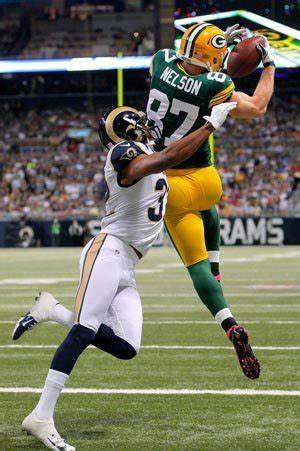

## Overview

## Business Problem

## Data Understanding

In [34]:
# Basics
import pandas as pd
import numpy as np
import itertools

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.pylab import rcParams
import time

# Modeling
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from sklearn.linear_model import LassoLarsCV
from fbprophet import Prophet as proph

# Warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings('ignore')

In [35]:
# load in player fantasy stats data as player_df
player_df = pd.read_csv('data/league_data/player_data/Yahoo-406.l.12345-Players.csv')
player_df.head()

,ID,OR,Last Name,First Name,Team,Status,Status Details,Eligible Positions,Avg. Pick,Avg. Round,...,Ret TD (DT),XPR (DT),Pts Allow 0 (DT),Pts Allow 1-6 (DT),Pts Allow 7-13 (DT),Pts Allow 14-20 (DT),Pts Allow 21-27 (DT),Pts Allow 28-34 (DT),Pts Allow 35+ (DT),Image
0,406.p.30977,1,Allen,Josh,Buf,Available,NaN,QB,29.7,3.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://s.yimg.com/iu/api/res/1.2/JqjwXUxHWb2L...
1,406.p.32676,2,Herbert,Justin,LAC,Available,NaN,QB,61.1,6.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://s.yimg.com/iu/api/res/1.2/j0W7BC4RRiJB...
2,406.p.5228,3,Brady,Tom,TB,Available,NaN,QB,63.5,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://s.yimg.com/iu/api/res/1.2/Z71ic_5aqQfG...
3,406.p.30123,4,Mahomes,Patrick,KC,Available,NaN,QB,16.6,2.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://s.yimg.com/iu/api/res/1.2/oMIJokh4hdPk...
4,406.p.30182,5,Kupp,Cooper,LAR,Available,NaN,WR,42.0,4.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://s.yimg.com/iu/api/res/1.2/hYxm3SR9yMjD...


In [36]:
# load in player fantasy points time series
wr_ts = pd.read_csv('data/wr_ts.csv')
wr_ts['Date'] = pd.to_datetime(wr_ts['Unnamed: 0'])
wr_ts = wr_ts.set_index('Date').drop('Unnamed: 0', axis=1)

qb_ts = pd.read_csv('data/qb_ts.csv')
qb_ts['Date'] = pd.to_datetime(qb_ts['Unnamed: 0'])
qb_ts = qb_ts.set_index('Date').drop('Unnamed: 0', axis=1)

rb_ts = pd.read_csv('data/rb_ts.csv')
rb_ts['Date'] = pd.to_datetime(rb_ts['Unnamed: 0'])
rb_ts = rb_ts.set_index('Date').drop('Unnamed: 0', axis=1)

te_ts = pd.read_csv('data/te_ts.csv')
te_ts['Date'] = pd.to_datetime(te_ts['Unnamed: 0'])
te_ts = te_ts.set_index('Date').drop('Unnamed: 0', axis=1)
qb_ts.head(20)

,Aaron Rodgers (GB),Baker Mayfield (CAR),Dak Prescott (DAL),Derek Carr (LV),Deshaun Watson (CLE),Jalen Hurts (PHI),Jameis Winston (NO),Joe Burrow (CIN),Josh Allen (BUF),Justin Fields (CHI),...,Mac Jones (NE),Matt Ryan (IND),Matthew Stafford (LAR),Patrick Mahomes II (KC),Russell Wilson (DEN),Ryan Tannehill (TEN),Tom Brady (TB),Trevor Lawrence (JAC),Trey Lance (SF),Tua Tagovailoa (MIA)
Date,,,,,,,,,,,,,,,,,,,,,
2017-09-07,16.5,NaN,17.1,18.7,5.7,NaN,NaN,NaN,NaN,NaN,...,NaN,17.9,27.1,NaN,8.3,NaN,10.7,NaN,NaN,NaN
2017-09-14,18.5,NaN,15.9,21.2,17.7,NaN,12.5,NaN,NaN,NaN,...,NaN,14.9,13.2,NaN,15.3,NaN,30.8,NaN,NaN,NaN
2017-09-21,24.8,NaN,22.9,5.2,20.1,NaN,15.5,NaN,NaN,NaN,...,NaN,13.7,16.5,NaN,33.5,NaN,35.7,NaN,NaN,NaN
2017-09-28,23.1,NaN,22.6,9.7,33.7,NaN,26.5,NaN,NaN,NaN,...,NaN,8.5,10.1,NaN,27.6,NaN,20.5,NaN,NaN,NaN
2017-10-05,24.0,NaN,29.7,NaN,35.5,NaN,18.5,NaN,NaN,NaN,...,NaN,NaN,15.2,NaN,11.5,NaN,12.6,NaN,NaN,NaN
2017-10-12,0.7,NaN,NaN,6.8,23.3,NaN,2.4,NaN,NaN,NaN,...,NaN,11.9,14.9,NaN,NaN,NaN,16.2,NaN,NaN,NaN
2017-10-19,NaN,NaN,30.0,30.2,NaN,NaN,23.4,NaN,NaN,NaN,...,NaN,17.0,NaN,NaN,26.4,NaN,18.5,NaN,NaN,NaN
2017-10-26,NaN,NaN,7.3,12.5,32.8,NaN,3.7,NaN,NaN,NaN,...,NaN,15.9,18.0,NaN,35.1,NaN,17.5,NaN,NaN,NaN
2017-11-02,NaN,NaN,26.7,13.7,NaN,NaN,3.5,NaN,NaN,NaN,...,NaN,18.4,22.4,NaN,23.6,NaN,NaN,NaN,NaN,NaN


In [54]:
# load in player fantasy stats data as player_df
qb_snap_ts = pd.read_csv('data/qb_snap_ts.csv')
qb_snap_ts['Date'] = pd.to_datetime(qb_snap_ts['Unnamed: 0'])
qb_snap_ts = qb_snap_ts.set_index('Date').drop('Unnamed: 0', axis=1)
qb_snap_ts = qb_snap_ts.reset_index()

In [55]:
qb_snap_ts

,Date,snaps_Aaron Rodgers (GB),snaps_Baker Mayfield (CAR),snaps_Dak Prescott (DAL),snaps_Derek Carr (LV),snaps_Deshaun Watson (CLE),snaps_Jalen Hurts (PHI),snaps_Jameis Winston (NO),snaps_Joe Burrow (CIN),snaps_Josh Allen (BUF),...,snaps_Mac Jones (NE),snaps_Matt Ryan (IND),snaps_Matthew Stafford (LAR),snaps_Patrick Mahomes II (KC),snaps_Russell Wilson (DEN),snaps_Ryan Tannehill (TEN),snaps_Tom Brady (TB),snaps_Trevor Lawrence (JAC),snaps_Trey Lance (SF),snaps_Tua Tagovailoa (MIA)
0,2017-09-07,82.0,NaN,74.0,66.0,48.0,NaN,NaN,NaN,NaN,...,NaN,59.0,NaN,0.0,49.0,NaN,NaN,NaN,NaN,NaN
1,2017-09-14,76.0,NaN,71.0,57.0,66.0,NaN,NaN,NaN,NaN,...,NaN,58.0,NaN,0.0,82.0,NaN,NaN,NaN,NaN,NaN
2,2017-09-21,70.0,NaN,47.0,51.0,71.0,NaN,NaN,NaN,NaN,...,NaN,68.0,NaN,0.0,73.0,NaN,NaN,NaN,NaN,NaN
3,2017-09-28,52.0,NaN,71.0,34.0,78.0,NaN,NaN,NaN,NaN,...,NaN,76.0,NaN,0.0,68.0,NaN,NaN,NaN,NaN,NaN
4,2017-10-05,60.0,NaN,74.0,0.0,64.0,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.0,68.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,2021-12-02,0.0,0.0,70.0,59.0,NaN,0.0,0.0,76.0,58.0,...,51.0,71.0,63.0,57.0,70.0,0.0,70.0,58.0,0.0,69.0
81,2021-12-09,63.0,63.0,85.0,63.0,NaN,0.0,0.0,67.0,78.0,...,0.0,69.0,58.0,62.0,61.0,68.0,83.0,55.0,0.0,0.0
82,2021-12-16,62.0,0.0,71.0,68.0,NaN,71.0,0.0,53.0,70.0,...,68.0,59.0,66.0,72.0,57.0,80.0,74.0,70.0,0.0,68.0
83,2021-12-23,59.0,68.0,61.0,69.0,NaN,56.0,0.0,76.0,79.0,...,64.0,46.0,70.0,63.0,56.0,62.0,64.0,73.0,0.0,61.0


Our filtered dataset contains a wide range of median home values, from a starting range of 53k to 427k for 105 zip codes in the SA metro area with several null values.  The null values are mostly contained in the early years of the data, but due to the massive growth of the area, there is data in the later years of the dataset.

## EDA

### Number of Zip Codes per City in SA Metro

NameError: name 'sa_df' is not defined

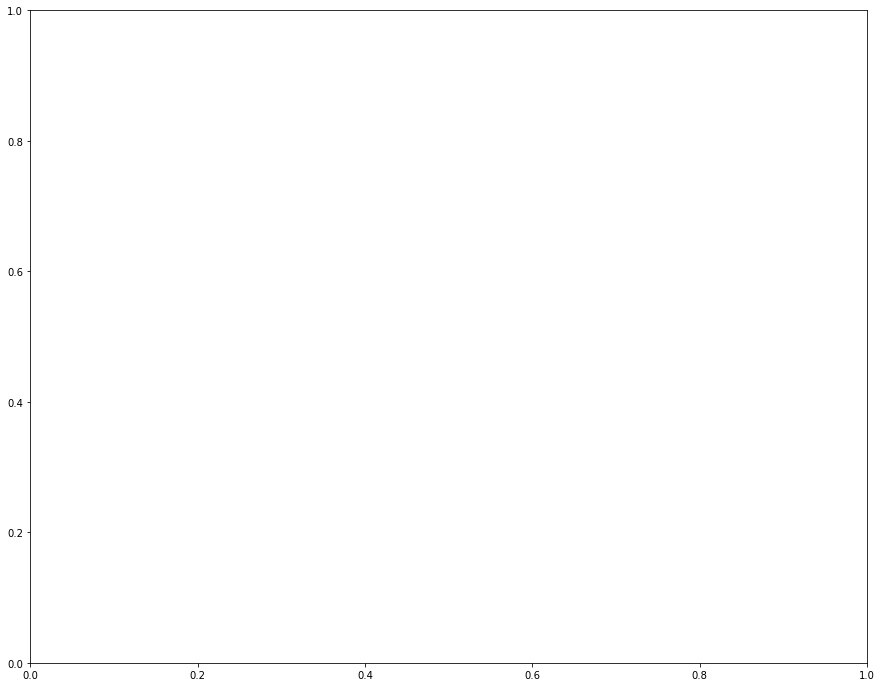

In [39]:
#Visualizing the value counts of zipcodes in each city in the San Antonio metro area

fig, ax = plt.subplots(figsize=(15,12))

y = [a for a in sa_df['City'].value_counts()]

x = [a for a in sa_df['City'].value_counts().keys()]

ax.barh(x,y,color='green')
ax.set_title('Cities in San Antonio Metro',fontsize=30)
ax.set_ylabel('Cities',fontsize=20)
ax.set_xlabel('Number of Zip codes in the City',fontsize=20)
fig.savefig('./images/zip_per_city.jpeg');

There are several small cities in the SA metro area that only have 1 zip code, while San Antonio itself contains 55 zip codes.

### Reshape from Wide to Long Format

The data needs to be melted from wide to long format in order to proceed with visualization and modeling.  Let's go ahead and do that now!

In [ ]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], format = '%Y-%m')
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [ ]:
# Get average of San Antonio metro zipcodes
satx_df_melted = melt_data(sa_df)
satx_df_melted.tail()

In [ ]:
# Get average of all US zipcodes
df_melted = melt_data(df)
df_melted.head()

### San Antonio vs US Median Home Prices

In order to compare how San Antonio home prices stack up the the US Median home price, I created a time series for the average median prices of the San Antonio area and a time series for the average median price of the US.  Plotted together, we can see the differences.

In [ ]:
# Plot home value time series for all zip codes averaged

# Define figure
ax = plt.figure(figsize=(20,12))

# Plot
plt.plot(satx_df_melted, label = 'San Antonio Median')
plt.plot(df_melted, label = 'US Median')

# Title, x & y labels
plt.title('San Antonio Metro vs US Median Home Sale Prices', fontsize=28)
plt.ylabel('Median Home Sale Prices (USD)', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.legend(loc='lower right', fontsize=18)
plt.savefig('./images/sa_vs_us.jpeg')

plt.show()

The median home value in San Antonio metro used to be much lower than the national average, but has actually surpassed it this year!  This is due to the massive growth in the area and the low inventory of homes that are available for sale.  We can also see that the housing market in San Antonio was not as affected by the crash in 2008.  I will leave all of the data in the model to provide my client with a more conservative model to forecast housing prices.

Next, I will create another time series that will contain all the location info in long format.

In [ ]:
#Create dataframe for new melted data
def melt_df(df):
    merged = []
    for zipcode in df.RegionName:
        melted = melt_data(df.loc[df['RegionName'] == zipcode])
        row = df.loc[df['RegionName'] == zipcode].iloc[:,:6]
        rows = pd.concat([row]*len(melted), ignore_index=True)
        merge = pd.concat([rows, melted.reset_index()], axis= 1)
        merged.append(merge)
    melted_df = pd.concat(merged)
    return melted_df

In [ ]:
satx_df = melt_df(sa_df)
satx_df.head()

In [ ]:
# Drop columns no longer needed
model_df = satx_df.drop(['RegionID','City','State','Metro','SizeRank'], axis ='columns').set_index('time')
model_df.head()

In [ ]:
model_df.info()

### Average Housing Prices In San Antonio Metro Over Time

Let's take a look at the time series plotted for all 105 zip codes.  We will be able to see the overall trend, but will be very dense on the plot.

In [ ]:
#plot the values grouped by zipcode
plt.figure(figsize=(20,14))
for zipcode in model_df.RegionName.unique():
    model_df.loc[model_df['RegionName'] == zipcode].value.plot(label=zipcode)
plt.legend(bbox_to_anchor=(1,1), loc='upper left', ncol=2)

plt.xlabel("Year", fontsize = 18)
plt.ylabel("Average Sale Price (USD)", fontsize=18)
plt.title('Average Housing Prices in San Antonio Metro from 2000-2022', fontsize = 20)
plt.savefig('./images/all_sa_prices.jpeg')
plt.show();


In [ ]:
# Which zipcode is the one with the highest median value?
model_df.loc[model_df['value'] >= 800000]

Much to my surprise, 78257 is outside of the main city loop.  These must be a development of custom luxury homes in Leon Springs.

### Zipcodes with Highest 5 Year ROI

In order to narrow down our focus before modeling, we will only keep 10 zip codes with highest ROI based on our last 5 years of historical data.  

In [ ]:
# Create copy of df to calculate ROIs
roi_df = sa_df.copy()
roi_df.head()

In [ ]:
# Calculate 5 year ROI and keep top 10
roi_df['roi_5_year'] = ((roi_df['2022-06-30'] - roi_df['2017-06-30'])/(roi_df['2017-06-30'])*100)
sa_5_year_roi = roi_df.sort_values('roi_5_year',ascending=False).head(10)
sa_5_year_roi['RegionName'] = sa_5_year_roi['RegionName'].astype(str)

#Plot
fig,ax=plt.subplots(figsize=(18,12))
sns.barplot('RegionName', 'roi_5_year', data = sa_5_year_roi)


zip_name_list = ['Arena District', 'Dignowity Hill', 'Gardendale', 'Kingsbury', 'Medina', 'Denver Heights', 
                 'Inner Westside', 'Fisher', 'Canyon Lake', 'Eastside']

#rotate the x-axis text and change to month name 
ax.set_xticklabels(zip_name_list, rotation = 45, size = 14)

# Axis labels and title
ax.set_ylabel('% ROI',fontsize='20')
ax.set_xlabel('Zipcodes',fontsize='20')
ax.set_title('Avg % Return on 5 Year Investment',fontsize='30')

#Save fig
plt.savefig('./images/roi_5_year.jpeg');

78203 contains the Arena District, which is the area surrounding the AT&T Center.  The other zip codes with highest ROI are spread all around the city in every direction. While most are around the downtown area, there are several suburbs like Canyon Lake and Medina that have taken the top ROI spots!

### Zip Codes with Highest 22 Year ROI

Out of curiosity, are the zip codes with the highest ROI over 22 years the same as the top 10 zip codes over the last 5 years?

In [ ]:
# Calculate 22 year ROI and keep top 10
roi_df['roi_22year'] = ((roi_df['2022-06-30'] - roi_df['2000-01-31'])/(roi_df['2000-01-31'])*100)
sa_22_year_roi = roi_df.sort_values('roi_22year',ascending=False).head(10)
sa_22_year_roi['RegionName'] = sa_22_year_roi['RegionName'].astype(str)

#Plot
fig,ax=plt.subplots(figsize=(18,12))
sns.barplot('RegionName', 'roi_22year', data = sa_22_year_roi)

zip_name_list_22 = ['Government Hill', 'Denver Heights', 'Arena District', 'Atascosa', 'Inner Eastside',
                 'Lytle', 'Aresenal / Lone Star', 'St Hedwig', 'Adkins', 'Dignowity Hill']

#rotate the x-axis text and change to month name 
ax.set_xticklabels(zip_name_list_22, rotation = 45, size = 14)

# Title and Axis Labels
ax.set_ylabel('% ROI',fontsize='20')
ax.set_xlabel('Zipcodes',fontsize='20')
ax.set_title('Avg % Return on 22 Year Investment',fontsize='30');

Only 3 zip codes that have the highest ROI on a 5 year investment are in the highest ROI over a 22 year investment.  This is once again due to new developments in the suburban areas, as well as gentrification of areas that were once undesirable.

### Seasonality EDA

According to the National Association of Realtors, the number of home sales increases significantly in the spring, with home sales increasing by 34% in February and March. Sales continue upward with the busiest home selling months being May through August, accounting for 40% of United States annual home sales volume. The slowest months are November through February. Prices of homes slightly increase during surge months when the demand in the market is higher. Therefore, selling homes during these peak times could prove to be advantageous for maximizing profits.[[4]](https://www.nar.realtor/blogs/economists-outlook/seasonality-in-the-housing-market) 

In order to study the seasonality in our data further and determine the best time of year to buy and sell houses in our top zip codes for maximizing profits, I am going to calculate the average 6 month ROI for winter and summer sales (i.e. a winter sale is a house that was purchased the previous summer and sold in the winter, while a summer sale is a house that was purchased during the winter and sold the next summer). I am going to calculate this over the last 5 years and take the average ROI gains for each time period.  

In [ ]:
# Calculate summer sale ROI
sa_5_year_roi['roi_summer_sale_2018'] = ((sa_5_year_roi['2018-07-31'] - sa_5_year_roi['2018-01-31'])/
                                         (sa_5_year_roi['2018-01-31'])*100)
sa_5_year_roi['roi_summer_sale_2019'] = ((sa_5_year_roi['2019-07-31'] - sa_5_year_roi['2019-01-31'])/
                                         (sa_5_year_roi['2019-01-31'])*100)
sa_5_year_roi['roi_summer_sale_2020'] = ((sa_5_year_roi['2020-07-31'] - sa_5_year_roi['2020-01-31'])/
                                         (sa_5_year_roi['2020-01-31'])*100)
sa_5_year_roi['roi_summer_sale_2021'] = ((sa_5_year_roi['2021-07-31'] - sa_5_year_roi['2021-01-31'])/
                                         (sa_5_year_roi['2021-01-31'])*100)
sa_5_year_roi['roi_summer_sale_2022'] = ((sa_5_year_roi['2022-06-30'] - sa_5_year_roi['2022-01-31'])/
                                         (sa_5_year_roi['2022-01-31'])*100)
sa_5_year_roi['average_summer_sale_roi'] = sa_5_year_roi[['roi_summer_sale_2018', 'roi_summer_sale_2019',
                                                          'roi_summer_sale_2020', 'roi_summer_sale_2021',
                                                          'roi_summer_sale_2022']].mean(axis=1).round(2)
#Calculate winter sale ROI
sa_5_year_roi['roi_winter_sale_2018'] = ((sa_5_year_roi['2018-01-31'] - sa_5_year_roi['2017-07-31'])/
                                         (sa_5_year_roi['2017-07-31'])*100)
sa_5_year_roi['roi_winter_sale_2019'] = ((sa_5_year_roi['2019-01-31'] - sa_5_year_roi['2018-07-31'])/
                                         (sa_5_year_roi['2018-07-31'])*100)
sa_5_year_roi['roi_winter_sale_2020'] = ((sa_5_year_roi['2020-01-31'] - sa_5_year_roi['2019-07-31'])/
                                         (sa_5_year_roi['2019-07-31'])*100)
sa_5_year_roi['roi_winter_sale_2021'] = ((sa_5_year_roi['2021-01-31'] - sa_5_year_roi['2020-07-31'])/
                                         (sa_5_year_roi['2020-07-31'])*100)
sa_5_year_roi['roi_winter_sale_2022'] = ((sa_5_year_roi['2022-01-31'] - sa_5_year_roi['2021-07-31'])/
                                         (sa_5_year_roi['2021-07-31'])*100)
sa_5_year_roi['average_winter_sale_roi'] = sa_5_year_roi[['roi_winter_sale_2018', 'roi_winter_sale_2019',
                                                          'roi_winter_sale_2020', 'roi_winter_sale_2021',
                                                          'roi_winter_sale_2022']].mean(axis=1).round(2)

# Sort rows by highest summer sale ROI
sa_summer_roi = sa_5_year_roi.sort_values('average_summer_sale_roi',ascending=False).head(10)

# Make column for neighborhood name
# Top 10 zip code names        
top_zip_names =  ['Gardendale', 'Kingsbury', 'Dignowity Hill', 'Inner Westside', 'Fisher', 
                 'Arena District', 'Canyon Lake', 'Medina', 'Denver Heights', 'Eastside']
sa_summer_roi['Neighborhood'] = top_zip_names

# Keep columns we want
sa_seasonal_roi = sa_summer_roi.reindex(columns=['RegionName', 'Neighborhood', 'average_summer_sale_roi',
                                                 'average_winter_sale_roi'])
sa_seasonal_roi

For most of our top zip codes, we can see about a 1% average ROI gain if we were to buy in the winter and sell in the summer.  Interestingly enough, 4 of our zip codes show higher ROI gains if we were to buy in the summer and sell in the winter.  The Arena District has over 2% higher ROI for a winter sale as opposed to a summer sale. A winter sale in Medina will increase ROI by 1%, while Denver Heights and the Eastside are about 0.5% increase. 

### Discussion on EDA

There is a similar trend amongst all of our neighborhoods in the SA metro area.  There is also a very wide range of median housing values, where the more affluent neighborhoods have a a much higher value than others.

We can also clearly see the housing bubble and 2008 crash in the data.  Values increased rapidly starting in 2004 and took a dip through 2009, plateaued, and begin rising again in 2012.  All zip codes in the San Antonio metro were mildly affected by this crash in comparison to the rest of the US.  A number of reasons contributed to this crash outside of the typical housing market highs and lows, and while they are rare, they do occur and are unpredictable.  I am going to leave this data in for our model to create a more conservative forecast for my client.

As discussed above, we know that there is going to be seasonality in our data and I will use SARIMAX for my time series model.  

## SARIMAX Modeling

### Create Time Series for Each Zip Code in Our Top 10

Our zip_df now contains a list of 10 time series for each of our 10 zipcodes of interest.

### Seasonal Decomposition

We can also decompose our time series to look for trend and seasonality.  

Let's start by looking at our top ROI zip code - 78203 (Arena District), and 78133 (Canyon Lake), which has had huge ROI gains in the last 2 years compared to all data in the dataset.

In [40]:
qb_list = []
for col in qb_ts.columns:
    player = qb_ts[col].squeeze()
    qb_list.append(player)
     
qb_list_names = []
for col in qb_ts.columns:
    player = col
    qb_list_names.append(player)

qb_list_names[0]

'Aaron Rodgers (GB)'

In [41]:
def decomposition_plot(ts):
    decomposition = sm.tsa.seasonal_decompose(ts, model='additive', period=16)

    #Gather the trend, seasonality, and residuals
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot gathered statistics
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(ts, label='Original', color='blue')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    plt.tight_layout();
    return decomposition_plot

In [42]:

qb_list[0] = qb_list[0].reset_index().drop('Date', axis=1).fillna(0)
qb_list[0]

,Aaron Rodgers (GB)
0,16.5
1,18.5
2,24.8
3,23.1
4,24.0
...,...
80,0.0
81,29.6
82,23.8
83,20.0


<function __main__.decomposition_plot(ts)>

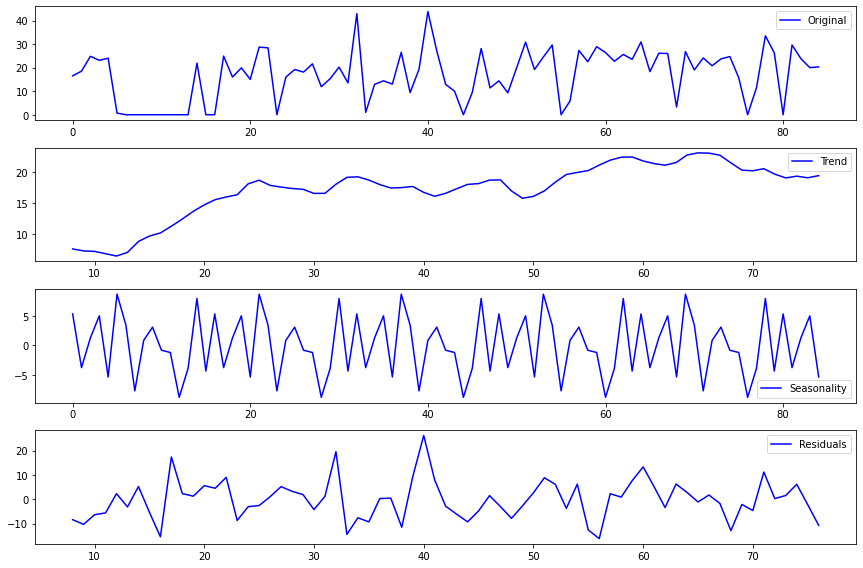

In [43]:
#Decomposition plot of the Arena District
decomposition_plot(qb_list[0])

In [44]:
qb_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 85 entries, 2017-09-07 to 2022-01-02
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Aaron Rodgers (GB)       72 non-null     float64
 1   Baker Mayfield (CAR)     63 non-null     float64
 2   Dak Prescott (DAL)       70 non-null     float64
 3   Derek Carr (LV)          80 non-null     float64
 4   Deshaun Watson (CLE)     71 non-null     float64
 5   Jalen Hurts (PHI)        32 non-null     float64
 6   Jameis Winston (NO)      61 non-null     float64
 7   Joe Burrow (CIN)         27 non-null     float64
 8   Josh Allen (BUF)         61 non-null     float64
 9   Justin Fields (CHI)      17 non-null     float64
 10  Justin Herbert (LAC)     32 non-null     float64
 11  Kirk Cousins (MIN)       80 non-null     float64
 12  Kyler Murray (ARI)       49 non-null     float64
 13  Lamar Jackson (BAL)      63 non-null     float64
 14  Mac Jone

We can clearly see the seasonality in the individual zip codes and the SA Median average.  There is also an overall upwards trend after the small dip after the housing bubble popped, with a steep increase over the last 2 years.

### Stationarity Check

In [45]:
def stationarity_check(TS):
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

In [46]:
# Get decomposition for stationarity check
decomposition = sm.tsa.seasonal_decompose(qb_list[0], model='additive', period=16)
residual = decomposition.resid
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

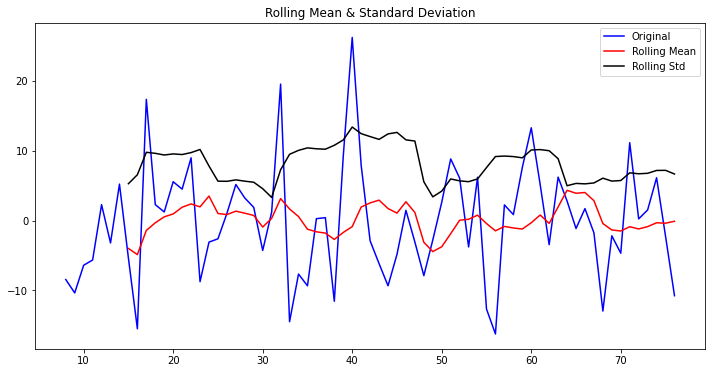

Results of Dickey-Fuller Test: 

Test Statistic                 -5.403261
p-value                         0.000003
#Lags Used                      5.000000
Number of Observations Used    63.000000
Critical Value (1%)            -3.538695
Critical Value (5%)            -2.908645
Critical Value (10%)           -2.591897
dtype: float64


In [47]:
stationarity_check(ts_log_decompose)

The p-value is <0.05, which means we accept the null hypothesis that the residuals are stationary. We can move on to check our autocorrelation and partial autocorrelation plots.

### Autocorrelation and Partial Autocorrelation

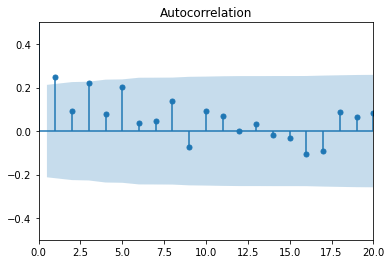

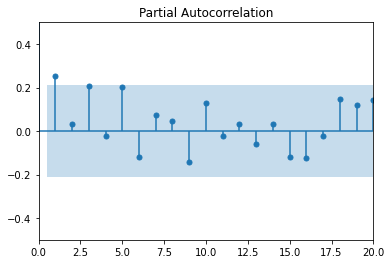

In [48]:
plot_acf(qb_list[0]); plt.xlim(0,20); plt.ylim(-0.5,0.5);plt.show()
plot_pacf(qb_list[0]); plt.xlim(0,20); plt.ylim(-0.5,0.5);plt.show()

There is a slow decline in our autocorrelation plot, while the partial autocorrelation drops off right away.  This means we should use an Autoregressive model for out data, but we are going to run gridsearch anyway to find best parameters.  We can try to plot again with a lag of 3, which would make sense for different seasons of the year.

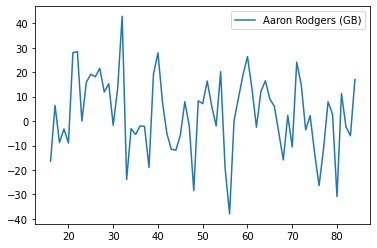

In [49]:
qb_list[0].diff(periods=16).plot();

We can see some autocorrelation at a lag of 3.

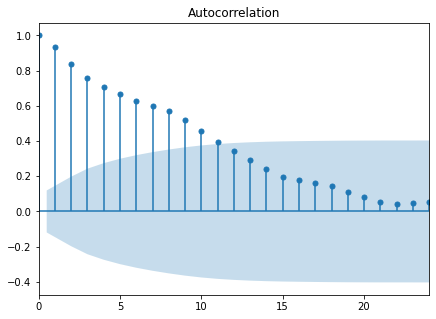

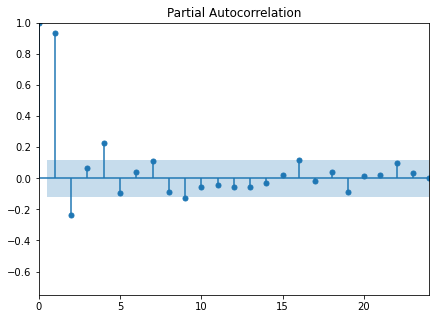

In [35]:
rcParams['figure.figsize']=7,5
plot_acf(satx_df_melted.diff(periods=3).bfill()); plt.xlim(0,24); plt.show()
plot_pacf(satx_df_melted.diff(periods=3).bfill()); plt.xlim(0,24); plt.ylim(-0.75,1);plt.show()

### Gridsearch for SARIMAX Model

Next, I am going to conduct gridsearch to find optimal values for (p,d,q) and (P,D,Q,s) ranked by lowest AIC. This will provide  optimal paramets for each of my 10 zip codes of interest.

In [95]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 16) for x in list(itertools.product(p, d, q))]

In [101]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for df, name in zip(qb_list, qb_list_names):
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                exog=
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([name, comb, combs, output.aic])
                print('Result for {}'.format(name) + ' ARIMA {} x {}16 : AIC Calculated = {}'.format(comb, combs, output.aic))
            except:
                continue


Result for Aaron Rodgers (GB) ARIMA (0, 0, 0) x (0, 0, 0, 16)16 : AIC Calculated = 641.5142048216811
Result for Aaron Rodgers (GB) ARIMA (0, 0, 0) x (0, 0, 1, 16)16 : AIC Calculated = 567.7796863802387
Result for Aaron Rodgers (GB) ARIMA (0, 0, 0) x (0, 1, 0, 16)16 : AIC Calculated = 599.2042567435891
Result for Aaron Rodgers (GB) ARIMA (0, 0, 0) x (0, 1, 1, 16)16 : AIC Calculated = 2067.642156494045
Result for Aaron Rodgers (GB) ARIMA (0, 0, 0) x (1, 0, 0, 16)16 : AIC Calculated = 591.1219905601207
Result for Aaron Rodgers (GB) ARIMA (0, 0, 0) x (1, 0, 1, 16)16 : AIC Calculated = 587.3995324505946
Result for Aaron Rodgers (GB) ARIMA (0, 0, 0) x (1, 1, 0, 16)16 : AIC Calculated = 425.07935339487074
Result for Aaron Rodgers (GB) ARIMA (0, 0, 0) x (1, 1, 1, 16)16 : AIC Calculated = 400.5451162984187
Result for Aaron Rodgers (GB) ARIMA (0, 0, 1) x (0, 0, 0, 16)16 : AIC Calculated = 596.5810184731422
Result for Aaron Rodgers (GB) ARIMA (0, 0, 1) x (0, 0, 1, 16)16 : AIC Calculated = 535.137

Result for Baker Mayfield (CAR) ARIMA (0, 1, 0) x (1, 0, 0, 16)16 : AIC Calculated = 479.9450194546185
Result for Baker Mayfield (CAR) ARIMA (0, 1, 0) x (1, 0, 1, 16)16 : AIC Calculated = 2591.3267739260505
Result for Baker Mayfield (CAR) ARIMA (0, 1, 0) x (1, 1, 0, 16)16 : AIC Calculated = 438.2419530031143
Result for Baker Mayfield (CAR) ARIMA (0, 1, 0) x (1, 1, 1, 16)16 : AIC Calculated = 417.810256644374
Result for Baker Mayfield (CAR) ARIMA (0, 1, 1) x (0, 0, 0, 16)16 : AIC Calculated = 440.8093494740381
Result for Baker Mayfield (CAR) ARIMA (0, 1, 1) x (0, 0, 1, 16)16 : AIC Calculated = 2306.8877207188093
Result for Baker Mayfield (CAR) ARIMA (0, 1, 1) x (0, 1, 0, 16)16 : AIC Calculated = 621.5838365647247
Result for Baker Mayfield (CAR) ARIMA (0, 1, 1) x (0, 1, 1, 16)16 : AIC Calculated = 375.3835213587553
Result for Baker Mayfield (CAR) ARIMA (0, 1, 1) x (1, 0, 0, 16)16 : AIC Calculated = 444.5438570427197
Result for Baker Mayfield (CAR) ARIMA (0, 1, 1) x (1, 0, 1, 16)16 : AIC 

Result for Dak Prescott (DAL) ARIMA (1, 0, 0) x (1, 1, 0, 16)16 : AIC Calculated = 323.0363017637597
Result for Dak Prescott (DAL) ARIMA (1, 0, 0) x (1, 1, 1, 16)16 : AIC Calculated = 308.9869831686984
Result for Dak Prescott (DAL) ARIMA (1, 0, 1) x (0, 0, 0, 16)16 : AIC Calculated = 508.457859912849
Result for Dak Prescott (DAL) ARIMA (1, 0, 1) x (0, 0, 1, 16)16 : AIC Calculated = 398.6691794107216
Result for Dak Prescott (DAL) ARIMA (1, 0, 1) x (0, 1, 0, 16)16 : AIC Calculated = 437.5309799196963
Result for Dak Prescott (DAL) ARIMA (1, 0, 1) x (0, 1, 1, 16)16 : AIC Calculated = 299.11311210272027
Result for Dak Prescott (DAL) ARIMA (1, 0, 1) x (1, 0, 0, 16)16 : AIC Calculated = 405.5405543875642
Result for Dak Prescott (DAL) ARIMA (1, 0, 1) x (1, 0, 1, 16)16 : AIC Calculated = 400.6535024885905
Result for Dak Prescott (DAL) ARIMA (1, 0, 1) x (1, 1, 0, 16)16 : AIC Calculated = 324.76263867509016
Result for Dak Prescott (DAL) ARIMA (1, 0, 1) x (1, 1, 1, 16)16 : AIC Calculated = 301.112

Result for Derek Carr (LV) ARIMA (1, 1, 1) x (0, 1, 1, 16)16 : AIC Calculated = 1861.6188039492658
Result for Derek Carr (LV) ARIMA (1, 1, 1) x (1, 0, 0, 16)16 : AIC Calculated = 447.2921204722119
Result for Derek Carr (LV) ARIMA (1, 1, 1) x (1, 0, 1, 16)16 : AIC Calculated = 441.8907018829729
Result for Derek Carr (LV) ARIMA (1, 1, 1) x (1, 1, 0, 16)16 : AIC Calculated = 372.39793117115215
Result for Derek Carr (LV) ARIMA (1, 1, 1) x (1, 1, 1, 16)16 : AIC Calculated = 2113.933468645774
Result for Deshaun Watson (CLE) ARIMA (0, 0, 0) x (0, 0, 0, 16)16 : AIC Calculated = 627.0041163487851
Result for Deshaun Watson (CLE) ARIMA (0, 0, 0) x (0, 0, 1, 16)16 : AIC Calculated = 550.7949790582786
Result for Deshaun Watson (CLE) ARIMA (0, 0, 0) x (0, 1, 0, 16)16 : AIC Calculated = 611.7659326716289
Result for Deshaun Watson (CLE) ARIMA (0, 0, 0) x (0, 1, 1, 16)16 : AIC Calculated = 2413.3945639401836
Result for Deshaun Watson (CLE) ARIMA (0, 0, 0) x (1, 0, 0, 16)16 : AIC Calculated = 581.770879

Result for Jalen Hurts (PHI) ARIMA (0, 0, 1) x (0, 1, 1, 16)16 : AIC Calculated = 406.0530724171509
Result for Jalen Hurts (PHI) ARIMA (0, 0, 1) x (1, 0, 0, 16)16 : AIC Calculated = 261.1710849613024
Result for Jalen Hurts (PHI) ARIMA (0, 0, 1) x (1, 0, 1, 16)16 : AIC Calculated = 263.1616609250714
Result for Jalen Hurts (PHI) ARIMA (0, 0, 1) x (1, 1, 0, 16)16 : AIC Calculated = 402.16602914354223
Result for Jalen Hurts (PHI) ARIMA (0, 0, 1) x (1, 1, 1, 16)16 : AIC Calculated = 402.9850031651303
Result for Jalen Hurts (PHI) ARIMA (0, 1, 0) x (0, 0, 0, 16)16 : AIC Calculated = 247.16968563990937
Result for Jalen Hurts (PHI) ARIMA (0, 1, 0) x (0, 0, 1, 16)16 : AIC Calculated = 245.12851484950662
Result for Jalen Hurts (PHI) ARIMA (0, 1, 0) x (0, 1, 0, 16)16 : AIC Calculated = 397.02516735201027
Result for Jalen Hurts (PHI) ARIMA (0, 1, 0) x (0, 1, 1, 16)16 : AIC Calculated = 410.24320199792896
Result for Jalen Hurts (PHI) ARIMA (0, 1, 0) x (1, 0, 0, 16)16 : AIC Calculated = 249.392525485

Result for Jameis Winston (NO) ARIMA (0, 1, 1) x (1, 1, 0, 16)16 : AIC Calculated = 334.9257001827025
Result for Jameis Winston (NO) ARIMA (0, 1, 1) x (1, 1, 1, 16)16 : AIC Calculated = 310.4303450614223
Result for Jameis Winston (NO) ARIMA (1, 0, 0) x (0, 0, 0, 16)16 : AIC Calculated = 477.6748297863265
Result for Jameis Winston (NO) ARIMA (1, 0, 0) x (0, 0, 1, 16)16 : AIC Calculated = 1627.8529680771908
Result for Jameis Winston (NO) ARIMA (1, 0, 0) x (0, 1, 0, 16)16 : AIC Calculated = 415.8092935683435
Result for Jameis Winston (NO) ARIMA (1, 0, 0) x (0, 1, 1, 16)16 : AIC Calculated = 335.5219756063913
Result for Jameis Winston (NO) ARIMA (1, 0, 0) x (1, 0, 0, 16)16 : AIC Calculated = 370.34395124008455
Result for Jameis Winston (NO) ARIMA (1, 0, 0) x (1, 0, 1, 16)16 : AIC Calculated = 2679.808029903601
Result for Jameis Winston (NO) ARIMA (1, 0, 0) x (1, 1, 0, 16)16 : AIC Calculated = 339.6041248104771
Result for Jameis Winston (NO) ARIMA (1, 0, 0) x (1, 1, 1, 16)16 : AIC Calculate

Result for Joe Burrow (CIN) ARIMA (1, 1, 0) x (1, 0, 1, 16)16 : AIC Calculated = 216.0258053909487
Result for Joe Burrow (CIN) ARIMA (1, 1, 0) x (1, 1, 0, 16)16 : AIC Calculated = 360.0078986416924
Result for Joe Burrow (CIN) ARIMA (1, 1, 0) x (1, 1, 1, 16)16 : AIC Calculated = 362.0078986552767
Result for Joe Burrow (CIN) ARIMA (1, 1, 1) x (0, 0, 0, 16)16 : AIC Calculated = 208.08244534775937
Result for Joe Burrow (CIN) ARIMA (1, 1, 1) x (0, 0, 1, 16)16 : AIC Calculated = 212.08098024629004
Result for Joe Burrow (CIN) ARIMA (1, 1, 1) x (0, 1, 0, 16)16 : AIC Calculated = 353.1692110098937
Result for Joe Burrow (CIN) ARIMA (1, 1, 1) x (0, 1, 1, 16)16 : AIC Calculated = 365.6988092495582
Result for Joe Burrow (CIN) ARIMA (1, 1, 1) x (1, 0, 0, 16)16 : AIC Calculated = 212.06671016744363
Result for Joe Burrow (CIN) ARIMA (1, 1, 1) x (1, 0, 1, 16)16 : AIC Calculated = 213.99305211359822
Result for Joe Burrow (CIN) ARIMA (1, 1, 1) x (1, 1, 0, 16)16 : AIC Calculated = 232.9599649448823
Result

Result for Justin Fields (CHI) ARIMA (0, 0, 1) x (0, 1, 1, 16)16 : AIC Calculated = 268.35652740015337
Result for Justin Fields (CHI) ARIMA (0, 0, 1) x (1, 0, 0, 16)16 : AIC Calculated = 130.06291317785528
Result for Justin Fields (CHI) ARIMA (0, 0, 1) x (1, 0, 1, 16)16 : AIC Calculated = 131.67360114399062
Result for Justin Fields (CHI) ARIMA (0, 0, 1) x (1, 1, 0, 16)16 : AIC Calculated = 267.54566654393705
Result for Justin Fields (CHI) ARIMA (0, 0, 1) x (1, 1, 1, 16)16 : AIC Calculated = 270.35652740015337
Result for Justin Fields (CHI) ARIMA (0, 1, 0) x (0, 0, 0, 16)16 : AIC Calculated = 139.3957679150263
Result for Justin Fields (CHI) ARIMA (0, 1, 0) x (0, 0, 1, 16)16 : AIC Calculated = 143.58957578560873
Result for Justin Fields (CHI) ARIMA (0, 1, 0) x (0, 1, 0, 16)16 : AIC Calculated = 268.803051174912
Result for Justin Fields (CHI) ARIMA (0, 1, 0) x (0, 1, 1, 16)16 : AIC Calculated = 282.11584137412046
Result for Justin Fields (CHI) ARIMA (0, 1, 0) x (1, 0, 0, 16)16 : AIC Calcu

Result for Justin Herbert (LAC) ARIMA (0, 1, 1) x (1, 0, 0, 16)16 : AIC Calculated = 251.28536879965625
Result for Justin Herbert (LAC) ARIMA (0, 1, 1) x (1, 0, 1, 16)16 : AIC Calculated = 252.9643752204771
Result for Justin Herbert (LAC) ARIMA (0, 1, 1) x (1, 1, 0, 16)16 : AIC Calculated = 401.6243890013813
Result for Justin Herbert (LAC) ARIMA (0, 1, 1) x (1, 1, 1, 16)16 : AIC Calculated = 404.7191598921894
Result for Justin Herbert (LAC) ARIMA (1, 0, 0) x (0, 0, 0, 16)16 : AIC Calculated = 257.45038027701406
Result for Justin Herbert (LAC) ARIMA (1, 0, 0) x (0, 0, 1, 16)16 : AIC Calculated = 259.1140500491905
Result for Justin Herbert (LAC) ARIMA (1, 0, 0) x (0, 1, 0, 16)16 : AIC Calculated = 381.5411267697904
Result for Justin Herbert (LAC) ARIMA (1, 0, 0) x (0, 1, 1, 16)16 : AIC Calculated = 394.24657898999334
Result for Justin Herbert (LAC) ARIMA (1, 0, 0) x (1, 0, 0, 16)16 : AIC Calculated = 259.2709754319492
Result for Justin Herbert (LAC) ARIMA (1, 0, 0) x (1, 0, 1, 16)16 : AI

Result for Kirk Cousins (MIN) ARIMA (1, 0, 1) x (1, 0, 1, 16)16 : AIC Calculated = 445.7289892052538
Result for Kirk Cousins (MIN) ARIMA (1, 0, 1) x (1, 1, 0, 16)16 : AIC Calculated = 372.1549986311683
Result for Kirk Cousins (MIN) ARIMA (1, 0, 1) x (1, 1, 1, 16)16 : AIC Calculated = 2218.0282013914452
Result for Kirk Cousins (MIN) ARIMA (1, 1, 0) x (0, 0, 0, 16)16 : AIC Calculated = 572.005222755809
Result for Kirk Cousins (MIN) ARIMA (1, 1, 0) x (0, 0, 1, 16)16 : AIC Calculated = 455.33432944992995
Result for Kirk Cousins (MIN) ARIMA (1, 1, 0) x (0, 1, 0, 16)16 : AIC Calculated = 501.7674956683858
Result for Kirk Cousins (MIN) ARIMA (1, 1, 0) x (0, 1, 1, 16)16 : AIC Calculated = 2402.667235605122
Result for Kirk Cousins (MIN) ARIMA (1, 1, 0) x (1, 0, 0, 16)16 : AIC Calculated = 460.781209606347
Result for Kirk Cousins (MIN) ARIMA (1, 1, 0) x (1, 0, 1, 16)16 : AIC Calculated = 457.2885266935233
Result for Kirk Cousins (MIN) ARIMA (1, 1, 0) x (1, 1, 0, 16)16 : AIC Calculated = 370.1958

Result for Kyler Murray (ARI) ARIMA (1, 1, 1) x (1, 1, 1, 16)16 : AIC Calculated = 516.6526433054646
Result for Lamar Jackson (BAL) ARIMA (0, 0, 0) x (0, 0, 0, 16)16 : AIC Calculated = 569.3512396158577
Result for Lamar Jackson (BAL) ARIMA (0, 0, 0) x (0, 0, 1, 16)16 : AIC Calculated = 2822.739750931597
Result for Lamar Jackson (BAL) ARIMA (0, 0, 0) x (0, 1, 0, 16)16 : AIC Calculated = 650.312592650353
Result for Lamar Jackson (BAL) ARIMA (0, 0, 0) x (0, 1, 1, 16)16 : AIC Calculated = 408.88062457172657
Result for Lamar Jackson (BAL) ARIMA (0, 0, 0) x (1, 0, 0, 16)16 : AIC Calculated = 571.2793618539329
Result for Lamar Jackson (BAL) ARIMA (0, 0, 0) x (1, 0, 1, 16)16 : AIC Calculated = 2686.470547201857
Result for Lamar Jackson (BAL) ARIMA (0, 0, 0) x (1, 1, 0, 16)16 : AIC Calculated = 428.54190983221014
Result for Lamar Jackson (BAL) ARIMA (0, 0, 0) x (1, 1, 1, 16)16 : AIC Calculated = 410.8177101950323
Result for Lamar Jackson (BAL) ARIMA (0, 0, 1) x (0, 0, 0, 16)16 : AIC Calculated 

Result for Mac Jones (NE) ARIMA (0, 1, 0) x (0, 1, 1, 16)16 : AIC Calculated = 282.11762611183315
Result for Mac Jones (NE) ARIMA (0, 1, 0) x (1, 0, 0, 16)16 : AIC Calculated = 143.3149667873072
Result for Mac Jones (NE) ARIMA (0, 1, 0) x (1, 0, 1, 16)16 : AIC Calculated = 145.3353121615264
Result for Mac Jones (NE) ARIMA (0, 1, 0) x (1, 1, 0, 16)16 : AIC Calculated = nan
Result for Mac Jones (NE) ARIMA (0, 1, 0) x (1, 1, 1, 16)16 : AIC Calculated = 278.74710897672884
Result for Mac Jones (NE) ARIMA (0, 1, 1) x (0, 0, 0, 16)16 : AIC Calculated = 131.5638503669563
Result for Mac Jones (NE) ARIMA (0, 1, 1) x (0, 0, 1, 16)16 : AIC Calculated = 134.56385168727607
Result for Mac Jones (NE) ARIMA (0, 1, 1) x (0, 1, 0, 16)16 : AIC Calculated = 271.4989673754738
Result for Mac Jones (NE) ARIMA (0, 1, 1) x (0, 1, 1, 16)16 : AIC Calculated = 284.8588481772869
Result for Mac Jones (NE) ARIMA (0, 1, 1) x (1, 0, 0, 16)16 : AIC Calculated = 134.82471481415106
Result for Mac Jones (NE) ARIMA (0, 1, 1

Result for Matt Ryan (IND) ARIMA (1, 0, 1) x (0, 1, 1, 16)16 : AIC Calculated = 1808.7813902587854
Result for Matt Ryan (IND) ARIMA (1, 0, 1) x (1, 0, 0, 16)16 : AIC Calculated = 455.1831754993752
Result for Matt Ryan (IND) ARIMA (1, 0, 1) x (1, 0, 1, 16)16 : AIC Calculated = 450.5454311658001
Result for Matt Ryan (IND) ARIMA (1, 0, 1) x (1, 1, 0, 16)16 : AIC Calculated = 371.01941285480336
Result for Matt Ryan (IND) ARIMA (1, 0, 1) x (1, 1, 1, 16)16 : AIC Calculated = 1809.8474832830766
Result for Matt Ryan (IND) ARIMA (1, 1, 0) x (0, 0, 0, 16)16 : AIC Calculated = 574.3119997118176
Result for Matt Ryan (IND) ARIMA (1, 1, 0) x (0, 0, 1, 16)16 : AIC Calculated = 476.65058146647425
Result for Matt Ryan (IND) ARIMA (1, 1, 0) x (0, 1, 0, 16)16 : AIC Calculated = 520.0558565597682
Result for Matt Ryan (IND) ARIMA (1, 1, 0) x (0, 1, 1, 16)16 : AIC Calculated = 2277.5942832806586
Result for Matt Ryan (IND) ARIMA (1, 1, 0) x (1, 0, 0, 16)16 : AIC Calculated = 476.71476053831805
Result for Mat

Result for Matthew Stafford (LAR) ARIMA (1, 1, 1) x (0, 1, 1, 16)16 : AIC Calculated = 296.5462590240037
Result for Matthew Stafford (LAR) ARIMA (1, 1, 1) x (1, 0, 0, 16)16 : AIC Calculated = 388.84721102499714
Result for Matthew Stafford (LAR) ARIMA (1, 1, 1) x (1, 0, 1, 16)16 : AIC Calculated = 382.4619542871352
Result for Matthew Stafford (LAR) ARIMA (1, 1, 1) x (1, 1, 0, 16)16 : AIC Calculated = 311.5391201094156
Result for Matthew Stafford (LAR) ARIMA (1, 1, 1) x (1, 1, 1, 16)16 : AIC Calculated = 302.319388213199
Result for Patrick Mahomes II (KC) ARIMA (0, 0, 0) x (0, 0, 0, 16)16 : AIC Calculated = 583.3718870135742
Result for Patrick Mahomes II (KC) ARIMA (0, 0, 0) x (0, 0, 1, 16)16 : AIC Calculated = 2531.2521234998767
Result for Patrick Mahomes II (KC) ARIMA (0, 0, 0) x (0, 1, 0, 16)16 : AIC Calculated = 598.8205607126906
Result for Patrick Mahomes II (KC) ARIMA (0, 0, 0) x (0, 1, 1, 16)16 : AIC Calculated = 360.9929371157709
Result for Patrick Mahomes II (KC) ARIMA (0, 0, 0)

Result for Russell Wilson (DEN) ARIMA (0, 0, 1) x (0, 1, 1, 16)16 : AIC Calculated = 1940.263802380456
Result for Russell Wilson (DEN) ARIMA (0, 0, 1) x (1, 0, 0, 16)16 : AIC Calculated = 505.99129309137913
Result for Russell Wilson (DEN) ARIMA (0, 0, 1) x (1, 0, 1, 16)16 : AIC Calculated = 482.5229773157388
Result for Russell Wilson (DEN) ARIMA (0, 0, 1) x (1, 1, 0, 16)16 : AIC Calculated = 401.56809358921834
Result for Russell Wilson (DEN) ARIMA (0, 0, 1) x (1, 1, 1, 16)16 : AIC Calculated = 1570.3942785496968
Result for Russell Wilson (DEN) ARIMA (0, 1, 0) x (0, 0, 0, 16)16 : AIC Calculated = 588.5860359348914
Result for Russell Wilson (DEN) ARIMA (0, 1, 0) x (0, 0, 1, 16)16 : AIC Calculated = 480.3195695384023
Result for Russell Wilson (DEN) ARIMA (0, 1, 0) x (0, 1, 0, 16)16 : AIC Calculated = 526.7111061409121
Result for Russell Wilson (DEN) ARIMA (0, 1, 0) x (0, 1, 1, 16)16 : AIC Calculated = 1974.7381561469485
Result for Russell Wilson (DEN) ARIMA (0, 1, 0) x (1, 0, 0, 16)16 : A

Result for Ryan Tannehill (TEN) ARIMA (0, 1, 1) x (0, 1, 1, 16)16 : AIC Calculated = 387.2542189055508
Result for Ryan Tannehill (TEN) ARIMA (0, 1, 1) x (1, 0, 0, 16)16 : AIC Calculated = 406.45430123883654
Result for Ryan Tannehill (TEN) ARIMA (0, 1, 1) x (1, 0, 1, 16)16 : AIC Calculated = 383.59039761541624
Result for Ryan Tannehill (TEN) ARIMA (0, 1, 1) x (1, 1, 0, 16)16 : AIC Calculated = 414.4105297311103
Result for Ryan Tannehill (TEN) ARIMA (0, 1, 1) x (1, 1, 1, 16)16 : AIC Calculated = 389.19138967808004
Result for Ryan Tannehill (TEN) ARIMA (1, 0, 0) x (0, 0, 0, 16)16 : AIC Calculated = 419.44202795272446
Result for Ryan Tannehill (TEN) ARIMA (1, 0, 0) x (0, 0, 1, 16)16 : AIC Calculated = 2922.4194946404878
Result for Ryan Tannehill (TEN) ARIMA (1, 0, 0) x (0, 1, 0, 16)16 : AIC Calculated = 564.5825050387648
Result for Ryan Tannehill (TEN) ARIMA (1, 0, 0) x (0, 1, 1, 16)16 : AIC Calculated = 403.6344329136231
Result for Ryan Tannehill (TEN) ARIMA (1, 0, 0) x (1, 0, 0, 16)16 : 

Result for Tom Brady (TB) ARIMA (1, 0, 1) x (1, 0, 1, 16)16 : AIC Calculated = 465.4528748294058
Result for Tom Brady (TB) ARIMA (1, 0, 1) x (1, 1, 0, 16)16 : AIC Calculated = 385.2864337676963
Result for Tom Brady (TB) ARIMA (1, 0, 1) x (1, 1, 1, 16)16 : AIC Calculated = 1910.0089424559917
Result for Tom Brady (TB) ARIMA (1, 1, 0) x (0, 0, 0, 16)16 : AIC Calculated = 598.2631426910176
Result for Tom Brady (TB) ARIMA (1, 1, 0) x (0, 0, 1, 16)16 : AIC Calculated = 492.7677511258559
Result for Tom Brady (TB) ARIMA (1, 1, 0) x (0, 1, 0, 16)16 : AIC Calculated = 540.6499443013141
Result for Tom Brady (TB) ARIMA (1, 1, 0) x (0, 1, 1, 16)16 : AIC Calculated = 2087.4397801646587
Result for Tom Brady (TB) ARIMA (1, 1, 0) x (1, 0, 0, 16)16 : AIC Calculated = 493.3215094228908
Result for Tom Brady (TB) ARIMA (1, 1, 0) x (1, 0, 1, 16)16 : AIC Calculated = 494.767663016583
Result for Tom Brady (TB) ARIMA (1, 1, 0) x (1, 1, 0, 16)16 : AIC Calculated = 405.03065867870333
Result for Tom Brady (TB) AR

Result for Trevor Lawrence (JAC) ARIMA (1, 1, 1) x (1, 1, 1, 16)16 : AIC Calculated = 283.17171091709093
Result for Trey Lance (SF) ARIMA (0, 0, 0) x (0, 0, 0, 16)16 : AIC Calculated = 121.44165768316084
Result for Trey Lance (SF) ARIMA (0, 0, 0) x (0, 0, 1, 16)16 : AIC Calculated = 123.44165665176331
Result for Trey Lance (SF) ARIMA (0, 0, 0) x (0, 1, 0, 16)16 : AIC Calculated = 262.01937362480965
Result for Trey Lance (SF) ARIMA (0, 0, 0) x (0, 1, 1, 16)16 : AIC Calculated = 265.9503801120452
Result for Trey Lance (SF) ARIMA (0, 0, 0) x (1, 0, 0, 16)16 : AIC Calculated = 123.44165673727734
Result for Trey Lance (SF) ARIMA (0, 0, 0) x (1, 0, 1, 16)16 : AIC Calculated = 125.44165664866155
Result for Trey Lance (SF) ARIMA (0, 0, 0) x (1, 1, 0, 16)16 : AIC Calculated = 265.544915003937
Result for Trey Lance (SF) ARIMA (0, 0, 0) x (1, 1, 1, 16)16 : AIC Calculated = 267.9503801120452
Result for Trey Lance (SF) ARIMA (0, 0, 1) x (0, 0, 0, 16)16 : AIC Calculated = 117.76452056523571
Result f

Result for Tua Tagovailoa (MIA) ARIMA (0, 1, 0) x (1, 1, 0, 16)16 : AIC Calculated = 363.25159734950444
Result for Tua Tagovailoa (MIA) ARIMA (0, 1, 0) x (1, 1, 1, 16)16 : AIC Calculated = 366.16505160766815
Result for Tua Tagovailoa (MIA) ARIMA (0, 1, 1) x (0, 0, 0, 16)16 : AIC Calculated = 211.84975277198748
Result for Tua Tagovailoa (MIA) ARIMA (0, 1, 1) x (0, 0, 1, 16)16 : AIC Calculated = 215.38030185513043
Result for Tua Tagovailoa (MIA) ARIMA (0, 1, 1) x (0, 1, 0, 16)16 : AIC Calculated = 351.48167926265586
Result for Tua Tagovailoa (MIA) ARIMA (0, 1, 1) x (0, 1, 1, 16)16 : AIC Calculated = 364.82293957605435
Result for Tua Tagovailoa (MIA) ARIMA (0, 1, 1) x (1, 0, 0, 16)16 : AIC Calculated = 215.52952373068308
Result for Tua Tagovailoa (MIA) ARIMA (0, 1, 1) x (1, 0, 1, 16)16 : AIC Calculated = 217.27174783996307
Result for Tua Tagovailoa (MIA) ARIMA (0, 1, 1) x (1, 1, 0, 16)16 : AIC Calculated = 360.34652958383225
Result for Tua Tagovailoa (MIA) ARIMA (0, 1, 1) x (1, 1, 1, 16)1

In [103]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['name', 'pdq', 'pdqs', 'aic'])
ans_df

,name,pdq,pdqs,aic
0,Aaron Rodgers (GB),"(0, 0, 0)","(0, 0, 0, 16)",641.514205
1,Aaron Rodgers (GB),"(0, 0, 0)","(0, 0, 1, 16)",567.779686
2,Aaron Rodgers (GB),"(0, 0, 0)","(0, 1, 0, 16)",599.204257
3,Aaron Rodgers (GB),"(0, 0, 0)","(0, 1, 1, 16)",2067.642156
4,Aaron Rodgers (GB),"(0, 0, 0)","(1, 0, 0, 16)",591.121991
...,...,...,...,...
1531,Tua Tagovailoa (MIA),"(1, 1, 1)","(0, 1, 1, 16)",366.643776
1532,Tua Tagovailoa (MIA),"(1, 1, 1)","(1, 0, 0, 16)",217.414816
1533,Tua Tagovailoa (MIA),"(1, 1, 1)","(1, 0, 1, 16)",219.115977
1534,Tua Tagovailoa (MIA),"(1, 1, 1)","(1, 1, 0, 16)",362.818001


In [104]:
#Return the best set of parameters based on AIC
best_para = ans_df.loc[ans_df.groupby("name")["aic"].idxmin()]
best_para

,name,pdq,pdqs,aic
27,Aaron Rodgers (GB),"(0, 1, 1)","(0, 1, 1, 16)",386.525869
107,Baker Mayfield (CAR),"(1, 0, 1)","(0, 1, 1, 16)",8.000000
155,Dak Prescott (DAL),"(0, 1, 1)","(0, 1, 1, 16)",292.216128
254,Derek Carr (LV),"(1, 1, 1)","(1, 1, 0, 16)",372.397931
283,Deshaun Watson (CLE),"(0, 1, 1)","(0, 1, 1, 16)",379.073322
376,Jalen Hurts (PHI),"(1, 1, 1)","(0, 0, 0, 16)",78.038114
411,Jameis Winston (NO),"(0, 1, 1)","(0, 1, 1, 16)",308.846827
480,Joe Burrow (CIN),"(1, 0, 0)","(0, 0, 0, 16)",203.164355
539,Josh Allen (BUF),"(0, 1, 1)","(0, 1, 1, 16)",418.655435
620,Justin Fields (CHI),"(1, 0, 1)","(1, 0, 0, 16)",74.648485


In [109]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm



model = pm.auto_arima(qb_list[0], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      exogeneous=qb_snap_ts['snaps_Aaron Rodgers (GB)'],
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=651.133, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=752.997, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=676.557, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=709.318, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=651.451, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=651.197, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=704.028, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=669.576, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=650.948, Time=0.07 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=652.931, Time=0.06 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=652.937, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=652.591, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=653.288, Time=0.04 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=648.018, 

### Best Parameters SARIMAX Model

Now that we have our optimal parameters for each zip code from our gridsearch, we will use the to build a sarimax model for each zip code.  Following are 3 functions we will use to build, evaluate and test each model, and forecast predictions for each of our top 10 zip codes.

In [56]:
exog = qb_snap_ts['snaps_Aaron Rodgers (GB)']
exog

0     82.0
1     76.0
2     70.0
3     52.0
4     60.0
      ... 
80     0.0
81    63.0
82    62.0
83    59.0
84    63.0
Name: snaps_Aaron Rodgers (GB), Length: 85, dtype: float64

In [53]:
qb_list[0]

,Aaron Rodgers (GB)
0,16.5
1,18.5
2,24.8
3,23.1
4,24.0
...,...
80,0.0
81,29.6
82,23.8
83,20.0


In [51]:
# Define function to build SARIMAX model, print summary and output diagnostic plots
def sarimax(ts, exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
    '''
    Input: 
    ts : Time series data.
    order : (p, d, q) values for ARIMA. Default = (1, 1, 1)
    seasonal_order : Seasonal (P, D, Q, s) values for SARIMA.
        Default = (1, 1, 1, 12).
        
    Output:
    Prints model output summary.
    Plots model diagnostics.
    
    Returns: Model output.
    '''
    
    # Sarimax model
    SARIMAX = sm.tsa.statespace.SARIMAX(ts,
                                        exog=exog,
                                        order=order, 
                                        seasonal_order=seasonal_order, 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)
                                            
    # Fit the model and print results
    output = SARIMAX.fit()
    
    # Print output summary
    print(output.summary().tables[1])
    output.plot_diagnostics(figsize=(15,18));
    
    return output

                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
snaps_Aaron Rodgers (GB)     0.3205      0.012     26.306      0.000       0.297       0.344
ar.L1                       -0.0417      0.121     -0.345      0.730      -0.279       0.195
sigma2                      50.5108      6.315      7.998      0.000      38.133      62.889


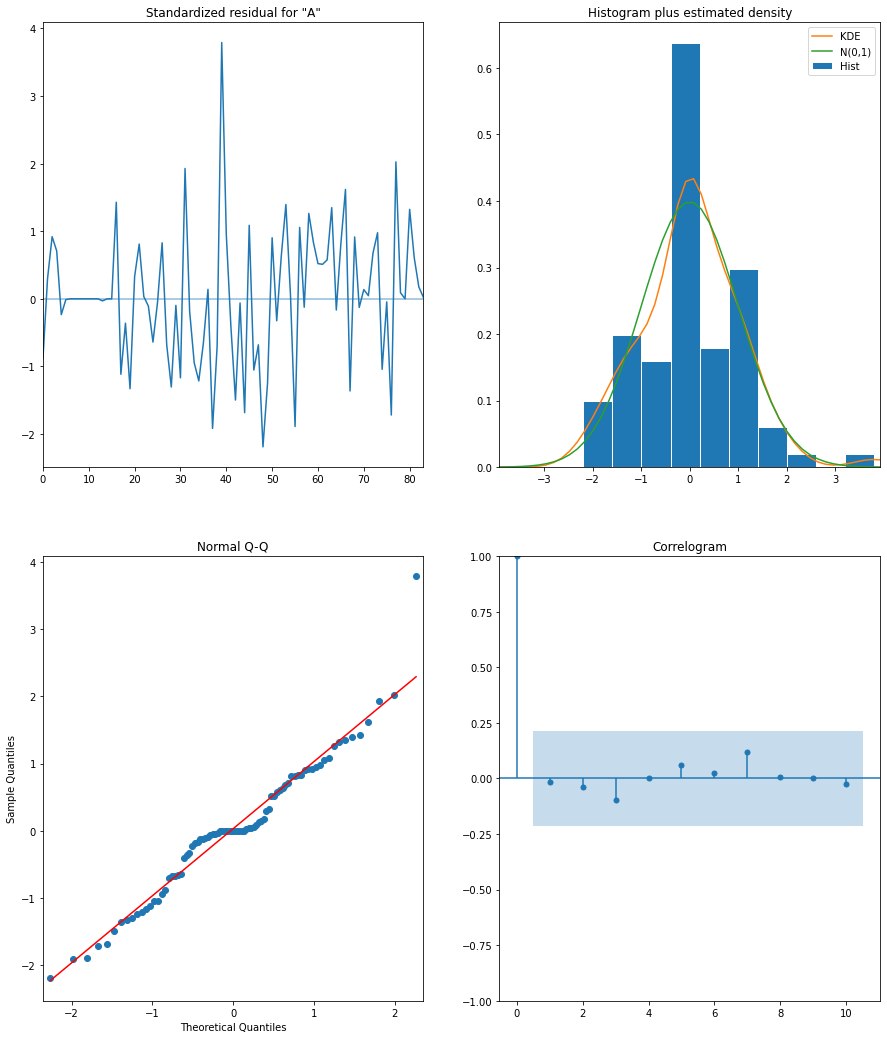

In [110]:
 AR_output = sarimax(qb_list[0], qb_snap_ts['snaps_Aaron Rodgers (GB)'], order=(1, 0, 0), seasonal_order=(0, 0, 0, 0))

In [42]:
def ose_forecast(ts, output, neighborhood =''):
    '''
    Plot forecast with real and predicted data.
    
    Input:
        ts : Time series.
        output : SARIMAX model output. 
        neighborhood : Name of city for plot title. 
        
    Output:
        Prints RMSE.
        Plots real vs. model predicted plot.
    '''

    # Get predictions starting from 2019-06-30 and calculate confidence intervals
    
    pred = output.get_prediction(start=pd.to_datetime('2019-06-30'), dynamic=False)
        
    # Get the real and predicted values
    ts_forecasted = pred.predicted_mean
    ts_truth = ts['2019-06-30':].value
    
    # Calc RMSE
    mse = mean_squared_error(ts_truth, ts_forecasted)
    rmse = np.sqrt(mse)

    # Print RMSE
    print('The RMSE of our forecasts is {}'.format(round(rmse, 2)))

    # Confidence Intervals
    pred_conf = pred.conf_int()

    ### Plot real vs predicted w/ confidence intervals ###

    rcParams['figure.figsize'] = 15, 6

    # Plot observed values
    ax = ts['2017-06-30':].plot(label='observed')

    # Plot predicted values
    
    ts_forecasted.plot(ax=ax, label='one-step ahead forecast', alpha=0.5)

    # Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='g', alpha=.3)
        
    # Title
    ax.set_title(neighborhood)

    # Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Median Home Value (USD)')
    plt.legend()

    return plt.show()

In [65]:
# Forecast 5 year predictions - Home Sale Values #

def dynamic_forecast(ts, model_output, exog, steps, player='', save_fig=False):
    '''
    Plots dynamic forecast for specified time into the future.
    
    Inputs: 
        ts : Time series data.
        model_output : Output results from our model.
        years : n-years to forcast into the future.
        neighborhood: Name of neighborhood for plots
            
    Outputs:
        Prints : Time series plot with one step ahead forecast.
        Returns : Dictionary of predictions.
    
    '''
    
    # Get forecast and confidence interval for steps ahead in future
    future = model_output.get_forecast(steps=steps, exog=exog, dynamic=True)
    future_conf = future.conf_int()
    
    ### Plot forecast ###
    
    # Observed
    ax = ts.plot(label='Observed', figsize=(12, 6))
    # Predicted
    future.predicted_mean.plot(ax=ax, label='dynamic forecast', alpha=0.9)

    # Confidence Intervals
    ax.fill_between(future_conf.index,
                    future_conf.iloc[:, 0],
                    future_conf.iloc[:, 1], color='k', alpha=.25)
    
    # Title
    ax.set_title(f"1 Year Forecast for {player}")
    
    # x & y-labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Median Home Sale Value (USD)')
    
    # Legend
    ax.legend()
    
    if save_fig:
        plt.savefig(f'./images/dynamic_forecast_{player}.jpeg')
    
    # Print plot
    plt.show()

    # Forecast prediction for n-years into the future
    forecast = future.predicted_mean
    maximum = future_conf.iloc[-1,1]
    minimum = future_conf.iloc[-1,0]
    
    # Create dictionary of predictions
    predictions = {}
    predictions['forecast'] = forecast.round()
    predictions['minimum'] = minimum.round()
    predictions['maximum'] = maximum.round()
    
    return predictions

In [90]:
qb_snap_ts['snaps_Aaron Rodgers (GB)'][-16:].replace(to_replace = 0, value=qb_snap_ts['snaps_Aaron Rodgers (GB)'].mean())


69    62.000000
70    63.000000
71    72.000000
72    64.000000
73    59.000000
74    56.000000
75    73.000000
76    52.388235
77    74.000000
78    58.000000
79    82.000000
80    52.388235
81    63.000000
82    62.000000
83    59.000000
84    63.000000
Name: snaps_Aaron Rodgers (GB), dtype: float64

In [102]:
exog_forecast

69    62.000000
70    63.000000
71    72.000000
72    64.000000
73    59.000000
74    56.000000
75    73.000000
76    52.388235
77    74.000000
78    58.000000
79    82.000000
80    52.388235
81    63.000000
82    62.000000
83    59.000000
84    63.000000
Name: snaps_Aaron Rodgers (GB), dtype: float64

In [103]:
exog_forecast = qb_snap_ts['snaps_Aaron Rodgers (GB)'][-16:].replace(to_replace = 0, 
                                                                     value=qb_snap_ts['snaps_Aaron Rodgers (GB)']
                                                                     .mean())
future = AR_output.get_forecast(steps=16, exog=exog_forecast, dynamic=True)
future_conf = future.conf_int()

In [104]:
forecast = future.predicted_mean

In [105]:
forecast[:17]

85     21.429861
86     22.099289
87     24.806122
88     22.112959
89     20.560714
90     19.676891
91     24.913795
92     18.602694
93     25.207632
94     20.307798
95     27.653541
96     18.593876
97     21.841269
98     21.534830
99     20.616659
100    21.840671
Name: predicted_mean, dtype: float64

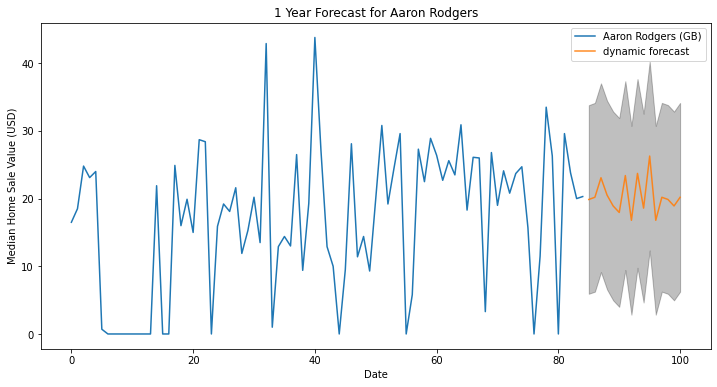

{'forecast': 85     20.0
 86     20.0
 87     23.0
 88     21.0
 89     19.0
 90     18.0
 91     23.0
 92     17.0
 93     24.0
 94     19.0
 95     26.0
 96     17.0
 97     20.0
 98     20.0
 99     19.0
 100    20.0
 Name: predicted_mean, dtype: float64,
 'minimum': 6.0,
 'maximum': 34.0}

In [111]:
dynamic_forecast(qb_list[0], AR_output, exog_forecast, 16, player='Aaron Rodgers', save_fig=False)


## Facebook Prophet Modeling

In [194]:
qb_fb_list = []
for col in qb_ts.columns:
    player = qb_ts[col].squeeze()
    qb_fb_list.append(player)

qb_fb_list[0]

Date
2017-09-07    16.5
2017-09-14    18.5
2017-09-21    24.8
2017-09-28    23.1
2017-10-05    24.0
2017-10-12     0.7
2017-10-19     NaN
2017-10-26     NaN
2017-11-02     NaN
2017-11-09     NaN
2017-11-16     NaN
2017-11-23     NaN
2017-11-30     NaN
2017-12-07     NaN
2017-12-14    21.9
2017-12-23     NaN
2017-12-31     NaN
2018-09-06    24.9
2018-09-13    16.0
2018-09-20    19.9
2018-09-27    15.0
2018-10-04    28.7
2018-10-11    28.4
2018-10-18     NaN
2018-10-25    15.9
2018-11-01    19.2
2018-11-08    18.1
2018-11-15    21.6
2018-11-22    11.9
2018-11-29    15.3
2018-12-06    20.2
2018-12-13    13.5
2018-12-22    42.9
2018-12-30     1.0
2019-09-05    12.9
2019-09-12    14.4
2019-09-19    13.0
2019-09-26    26.5
2019-10-03     9.4
2019-10-10    19.3
2019-10-17    43.8
2019-10-24    27.1
2019-10-31    12.9
2019-11-07    10.0
2019-11-14     NaN
2019-11-21     9.5
2019-11-28    28.1
2019-12-05    11.4
2019-12-12    14.4
2019-12-20     9.3
2019-12-27    20.0
2020-09-10    30.8
2020-09

In [195]:
# Set the uncertainty interval to 95% (the Prophet default is 80%)
Model = proph(interval_width=0.95)

In [196]:
# Rename the columns [Month, AirPassengers] to [ds, y]
qb_fb_list[0] = qb_fb_list[0].reset_index().rename(columns={'Date': 'ds',
                                                     'Aaron Rodgers (GB)': 'y'})
qb_fb_list[0]

,ds,y
0,2017-09-07,16.5
1,2017-09-14,18.5
2,2017-09-21,24.8
3,2017-09-28,23.1
4,2017-10-05,24.0
5,2017-10-12,0.7
6,2017-10-19,NaN
7,2017-10-26,NaN
8,2017-11-02,NaN
9,2017-11-09,NaN


In [197]:
bye = [6, 23, 44, 55, 76, 0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
qb_fb_list[0] = qb_fb_list[0].drop(bye).fillna(0)
qb_fb_list[0]

,ds,y
17,2018-09-06,24.9
18,2018-09-13,16.0
19,2018-09-20,19.9
20,2018-09-27,15.0
21,2018-10-04,28.7
22,2018-10-11,28.4
24,2018-10-25,15.9
25,2018-11-01,19.2
26,2018-11-08,18.1
27,2018-11-15,21.6


In [198]:
# Fit the timeseries to Model
Model.fit(qb_fb_list[0])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [199]:
# Use make_future_dataframe() with a monthly frequency and periods = 36 for 3 years
future_dates = Model.make_future_dataframe(periods=16, freq='W')
future_dates.head()

,ds
0,2018-09-06
1,2018-09-13
2,2018-09-20
3,2018-09-27
4,2018-10-04


In [200]:
# Predict the values for future dates and take the head of forecast
forecast = Model.predict(future_dates)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-09-06,-7.862235,2.172470,30.107701,-7.862235,-7.862235,24.540196,24.540196,24.540196,-3.062094,-3.062094,-3.062094,27.602289,27.602289,27.602289,0.0,0.0,0.0,16.677961
1,2018-09-13,-7.852499,0.657286,31.280306,-7.852499,-7.852499,23.808259,23.808259,23.808259,-3.062094,-3.062094,-3.062094,26.870353,26.870353,26.870353,0.0,0.0,0.0,15.955761
2,2018-09-20,-7.842763,3.609367,33.296033,-7.842763,-7.842763,26.748040,26.748040,26.748040,-3.062094,-3.062094,-3.062094,29.810134,29.810134,29.810134,0.0,0.0,0.0,18.905278
3,2018-09-27,-7.833026,5.927686,34.170424,-7.833026,-7.833026,28.267398,28.267398,28.267398,-3.062094,-3.062094,-3.062094,31.329492,31.329492,31.329492,0.0,0.0,0.0,20.434372
4,2018-10-04,-7.823290,8.542968,35.648957,-7.823290,-7.823290,29.069314,29.069314,29.069314,-3.062094,-3.062094,-3.062094,32.131407,32.131407,32.131407,0.0,0.0,0.0,21.246024


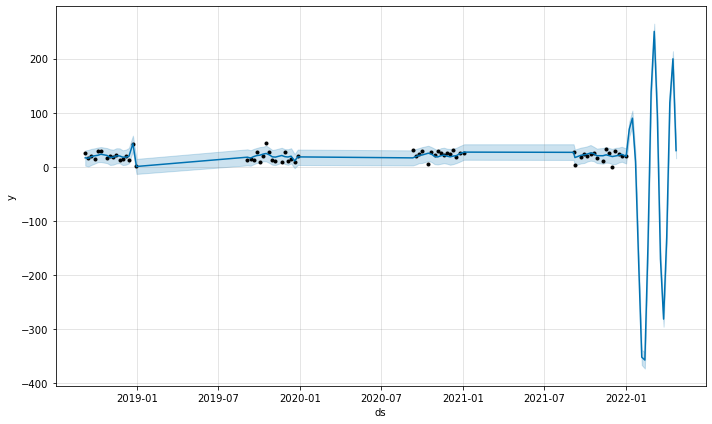

In [201]:
# Use Prophet's plot method to plot the predictions
Model.plot(forecast, uncertainty=True)
plt.show()

In [ ]:
m = proph()
m.fit(qb_fb_list[0])

#%% Forecast 1 year
weeks = 16
future = m.make_future_dataframe(periods=weeks)
future.tail()

fig1 = m.plot(forecast)
plt.close()
fig2 = m.plot_components(forecast)


## Interpret Results

### Projections for 3 and 5 year ROI

I am now going to make a dataframe that will contain our projected metrics based upon our sarimax model forecasting.

In [74]:
def projections(ts, zipcodes, years):
    '''
    Calculate projections for each zip code.
        - Current Value
        - ROI (return on investment)
        
    Input:
        ts : time series data.
        zipcodes : list of zip codes to iterate through.
        years : n-number of years to forecast.
        
    Output:
        Returns dataframe with:
        - zip code
        - investment value (current value)
        - predicted value and errors
        - predicted ROI and errors

    '''
    
    # Define steps for forecasting
    steps = years*12
    
    # Create list to append projection metrics
    projections = []
    
    # Iterate through time series of each zip code
    for zipcode in zipcodes:
        
        # Time series of zip code
        zip_ts = ts[ts['RegionName'] == zipcode]
        to_drop = ['RegionName']
        zip_ts = zip_ts.drop(to_drop, axis=1)
        
        # Plug the optimal parameter values into a new SARIMAX model
        # I used the values that were the most frequent for out top 10 zipcodes
        SARIMAX = sm.tsa.statespace.SARIMAX(zip_ts,
                                            order=(1, 1, 1),
                                            seasonal_order=(1, 1, 1, 12),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

        # Fit the model and print results
        output = SARIMAX.fit()
    
        # Get forecast and confidence interval for steps ahead in future
        forecast = output.get_forecast(steps=steps, dynamic=True)
        conf_int = forecast.conf_int()

        # Show prediction for end of step-period
        pred_mean = forecast.predicted_mean[-1]
        pred_mean_min = conf_int.iloc[-1,0]
        pred_mean_max = conf_int.iloc[-1,1]
        
        # Last value of the time series - this will be used to calculate projected ROI
        current_value = zip_ts['value'][-1]
        
        # ROI (Return on Investment) as Percentage
        ROI = ((pred_mean-current_value)/current_value *100)
        ROI_min = ((pred_mean_min-current_value)/current_value *100)
        ROI_max = ((pred_mean_max-current_value)/current_value *100)
        
        # Create DataFrame
        
        # Initiate empty dictionary
        predicted = {}

        # Columns for df
        predicted['Zip Code'] = zipcode
        predicted['Investment Value ($)'] = current_value.round(2)
        predicted['Predicted Sale Price ($)'] = pred_mean.round(2)
        predicted['Min Pred Sale Price ($)'] = pred_mean_min.round(2)
        predicted['Max Pred Sale Price ($)'] = pred_mean_max.round(2)
        predicted['Predicted ROI (%)'] = ROI.round()
        predicted['Min Pred ROI (%)'] = ROI_min.round()
        predicted['Max Pred ROI (%)'] = ROI_max.round()
        
        # Append to list
        projections.append(predicted)
        
        # Return in DataFrame format     
    return pd.DataFrame.from_dict(projections)

In [75]:
# Get 3 year projections for top 10 zip codes
three_year_projections = projections(model_df, zip_list, years=3)
three_year_projections

,Zip Code,Investment Value ($),Predicted Sale Price ($),Min Pred Sale Price ($),Max Pred Sale Price ($),Predicted ROI (%),Min Pred ROI (%),Max Pred ROI (%)
0,78203,241568.0,339839.66,283808.21,395871.11,41.0,17.0,64.0
1,78202,228219.0,316210.20,277737.86,354682.55,39.0,22.0,55.0
2,78207,148461.0,217501.24,180366.22,254636.25,47.0,21.0,72.0
3,78638,555727.0,930184.77,673410.44,1186959.09,67.0,21.0,114.0
4,78055,361314.0,569344.07,465645.71,673042.44,58.0,29.0,86.0
5,78210,234712.0,337287.14,295798.77,378775.51,44.0,26.0,61.0
6,78237,163415.0,237227.36,199425.67,275029.05,45.0,22.0,68.0
7,78623,509544.0,827218.41,638932.68,1015504.15,62.0,25.0,99.0
8,78133,473175.0,837285.82,594395.25,1080176.39,77.0,26.0,128.0
9,78220,183720.0,260936.10,226854.29,295017.91,42.0,23.0,61.0


In [76]:
# Make column for neighborhood name
# Top 10 zip code names        
top_10_names =  ['Arena District', 'Dignowity Hill', 'Gardendale', 'Kingsbury', 'Medina', 
                 'Denver Heights', 'Inner Westside', 'Fisher', 'Canyon Lake', 'Eastside']
three_year_projections['Neighborhood'] = top_10_names
three_year_projections = three_year_projections.reindex(columns=['Neighborhood', 'Zip Code', 'Investment Value ($)',
                                                                 'Predicted Sale Price ($)', 'Min Pred Sale Price ($)',
                                                                 'Max Pred Sale Price ($)', 'Predicted ROI (%)', 
                                                                 'Min Pred ROI (%)', 'Max Pred ROI (%)'])
three_year_projections.set_index('Neighborhood')

,Zip Code,Investment Value ($),Predicted Sale Price ($),Min Pred Sale Price ($),Max Pred Sale Price ($),Predicted ROI (%),Min Pred ROI (%),Max Pred ROI (%)
Neighborhood,,,,,,,,
Arena District,78203,241568.0,339839.66,283808.21,395871.11,41.0,17.0,64.0
Dignowity Hill,78202,228219.0,316210.20,277737.86,354682.55,39.0,22.0,55.0
Gardendale,78207,148461.0,217501.24,180366.22,254636.25,47.0,21.0,72.0
Kingsbury,78638,555727.0,930184.77,673410.44,1186959.09,67.0,21.0,114.0
Medina,78055,361314.0,569344.07,465645.71,673042.44,58.0,29.0,86.0
Denver Heights,78210,234712.0,337287.14,295798.77,378775.51,44.0,26.0,61.0
Inner Westside,78237,163415.0,237227.36,199425.67,275029.05,45.0,22.0,68.0
Fisher,78623,509544.0,827218.41,638932.68,1015504.15,62.0,25.0,99.0
Canyon Lake,78133,473175.0,837285.82,594395.25,1080176.39,77.0,26.0,128.0


In [77]:
# Get 5 year projections for top 10 zip codes
five_year_projections = projections(model_df, zip_list, years=5)
five_year_projections

,Zip Code,Investment Value ($),Predicted Sale Price ($),Min Pred Sale Price ($),Max Pred Sale Price ($),Predicted ROI (%),Min Pred ROI (%),Max Pred ROI (%)
0,78203,241568.0,405675.97,301026.60,510325.34,68.0,25.0,111.0
1,78202,228219.0,374877.90,303162.47,446593.33,64.0,33.0,96.0
2,78207,148461.0,264755.34,195127.43,334383.26,78.0,31.0,125.0
3,78638,555727.0,1187523.76,698988.57,1676058.95,114.0,26.0,202.0
4,78055,361314.0,708782.46,507903.17,909661.75,96.0,41.0,152.0
5,78210,234712.0,406120.38,327701.41,484539.36,73.0,40.0,106.0
6,78237,163415.0,287589.35,215798.43,359380.27,76.0,32.0,120.0
7,78623,509544.0,1048415.61,669826.72,1427004.49,106.0,31.0,180.0
8,78133,473175.0,1093740.35,582965.84,1604514.85,131.0,23.0,239.0
9,78220,183720.0,313951.99,249978.26,377925.71,71.0,36.0,106.0


In [78]:
# Set neighborhood names for five year projections df
five_year_projections['Neighborhood'] = top_10_names
five_year_projections = five_year_projections.reindex(columns=['Neighborhood', 'Zip Code', 'Investment Value ($)',
                                                               'Predicted Sale Price ($)', 'Min Pred Sale Price ($)',
                                                               'Max Pred Sale Price ($)', 'Predicted ROI (%)', 
                                                               'Min Pred ROI (%)', 'Max Pred ROI (%)'])
five_year_projections.set_index('Neighborhood')

,Zip Code,Investment Value ($),Predicted Sale Price ($),Min Pred Sale Price ($),Max Pred Sale Price ($),Predicted ROI (%),Min Pred ROI (%),Max Pred ROI (%)
Neighborhood,,,,,,,,
Arena District,78203,241568.0,405675.97,301026.60,510325.34,68.0,25.0,111.0
Dignowity Hill,78202,228219.0,374877.90,303162.47,446593.33,64.0,33.0,96.0
Gardendale,78207,148461.0,264755.34,195127.43,334383.26,78.0,31.0,125.0
Kingsbury,78638,555727.0,1187523.76,698988.57,1676058.95,114.0,26.0,202.0
Medina,78055,361314.0,708782.46,507903.17,909661.75,96.0,41.0,152.0
Denver Heights,78210,234712.0,406120.38,327701.41,484539.36,73.0,40.0,106.0
Inner Westside,78237,163415.0,287589.35,215798.43,359380.27,76.0,32.0,120.0
Fisher,78623,509544.0,1048415.61,669826.72,1427004.49,106.0,31.0,180.0
Canyon Lake,78133,473175.0,1093740.35,582965.84,1604514.85,131.0,23.0,239.0


In [79]:
# Sort values based on ROI for 3 year projections
three_year_projections.sort_values('Predicted ROI (%)')

,Neighborhood,Zip Code,Investment Value ($),Predicted Sale Price ($),Min Pred Sale Price ($),Max Pred Sale Price ($),Predicted ROI (%),Min Pred ROI (%),Max Pred ROI (%)
1,Dignowity Hill,78202,228219.0,316210.20,277737.86,354682.55,39.0,22.0,55.0
0,Arena District,78203,241568.0,339839.66,283808.21,395871.11,41.0,17.0,64.0
9,Eastside,78220,183720.0,260936.10,226854.29,295017.91,42.0,23.0,61.0
5,Denver Heights,78210,234712.0,337287.14,295798.77,378775.51,44.0,26.0,61.0
6,Inner Westside,78237,163415.0,237227.36,199425.67,275029.05,45.0,22.0,68.0
2,Gardendale,78207,148461.0,217501.24,180366.22,254636.25,47.0,21.0,72.0
4,Medina,78055,361314.0,569344.07,465645.71,673042.44,58.0,29.0,86.0
7,Fisher,78623,509544.0,827218.41,638932.68,1015504.15,62.0,25.0,99.0
3,Kingsbury,78638,555727.0,930184.77,673410.44,1186959.09,67.0,21.0,114.0
8,Canyon Lake,78133,473175.0,837285.82,594395.25,1080176.39,77.0,26.0,128.0


In [80]:
# Sort values based on ROI for 5 year projections
five_year_projections.sort_values('Predicted ROI (%)')

,Neighborhood,Zip Code,Investment Value ($),Predicted Sale Price ($),Min Pred Sale Price ($),Max Pred Sale Price ($),Predicted ROI (%),Min Pred ROI (%),Max Pred ROI (%)
1,Dignowity Hill,78202,228219.0,374877.90,303162.47,446593.33,64.0,33.0,96.0
0,Arena District,78203,241568.0,405675.97,301026.60,510325.34,68.0,25.0,111.0
9,Eastside,78220,183720.0,313951.99,249978.26,377925.71,71.0,36.0,106.0
5,Denver Heights,78210,234712.0,406120.38,327701.41,484539.36,73.0,40.0,106.0
6,Inner Westside,78237,163415.0,287589.35,215798.43,359380.27,76.0,32.0,120.0
2,Gardendale,78207,148461.0,264755.34,195127.43,334383.26,78.0,31.0,125.0
4,Medina,78055,361314.0,708782.46,507903.17,909661.75,96.0,41.0,152.0
7,Fisher,78623,509544.0,1048415.61,669826.72,1427004.49,106.0,31.0,180.0
3,Kingsbury,78638,555727.0,1187523.76,698988.57,1676058.95,114.0,26.0,202.0
8,Canyon Lake,78133,473175.0,1093740.35,582965.84,1604514.85,131.0,23.0,239.0


Our projections for 3 years and 5 years have the same ranking order of each zip code which is great. In order to aid visualization, I am going to write a function to produce a bar plot with predicted ROI and errors associated with each zip code.

### Barplots of ROI Projections and Errors

In [81]:
# Barplot for x years projection with 95% confidence intervals
def projection_barplot(df, years=3, save_fig=False):
    # Plot Predicted Mean Home Sale Values #

    # Get errors; (pred mean - lower bound of conf interval)
    errors = df['Predicted ROI (%)'] - df['Min Pred ROI (%)']
    df['errors'] = errors

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Plot barplot of ROI with errors
    plt.rcParams.update({'font.size': 18})
    df.plot(x='Neighborhood', 
            y='Predicted ROI (%)', 
            kind='bar',
            ax=ax, 
            color='none', 
            ecolor='black',
            capsize=10,
            yerr='errors', 
            legend=False)
    #Labels
    ax.set_xlabel('Neighborhood')
    ax.set_ylabel('Predicted ROI (%)')
    plt.title(f'{years} Year ROI w/ 95% Confidence Intervals')

    # Predicted ROI
    ax.scatter(x=pd.np.arange(df.shape[0]),
               marker='s', 
               s=40, 
               y=df['Predicted ROI (%)'], 
               color='black')
    
    # Line to help visualize on the y-axis
    ax.axhline(y=50, linestyle='--', color='red', linewidth=1.5)
    
    if save_fig:
        fig.savefig(f'./images/barplot_{years}.jpeg')
    
    # Rotate zip code labels 45 degrees
    plt.xticks(rotation = 45, size = 14)
    plt.show();

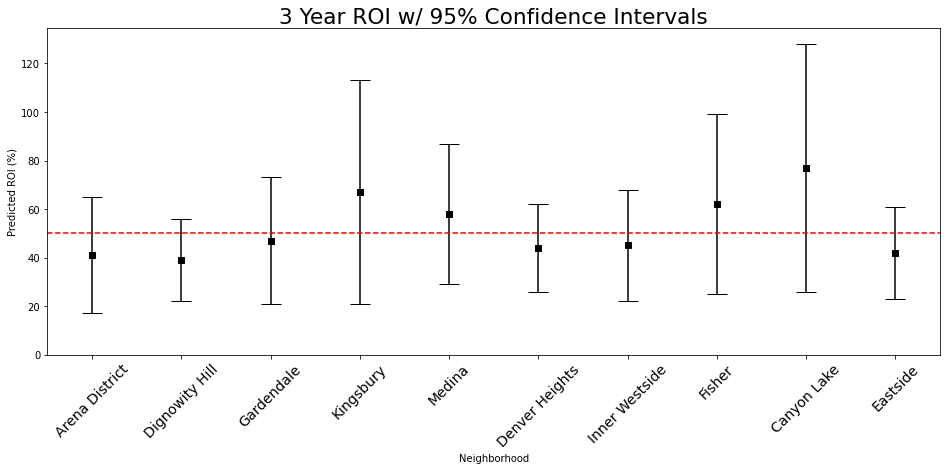

In [82]:
# 3 year ROI projections
projection_barplot(three_year_projections, years=3)

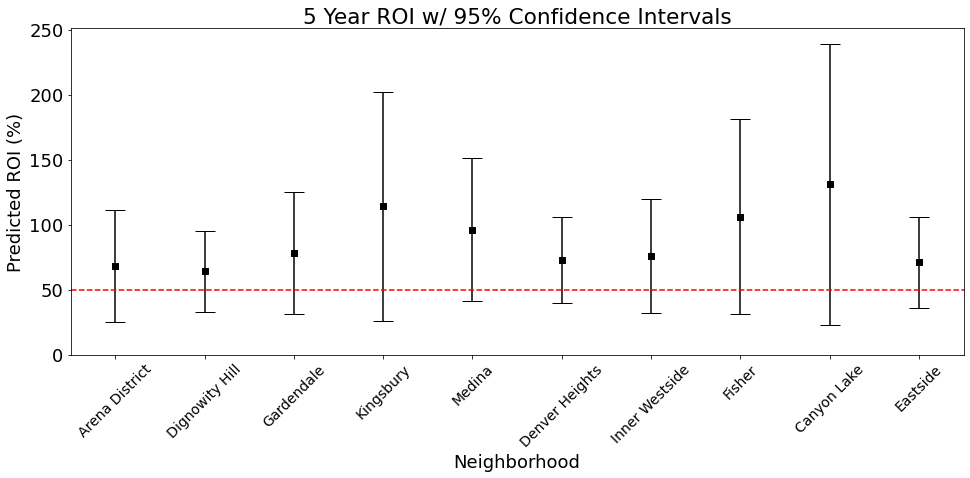

In [83]:
# 5 year ROI projections
projection_barplot(five_year_projections, years=5)

Since my client very concerned with low risk investments, I am going to select the top 5 zip codes from this list with the smallest confidence intervals.  This will remove those zip codes that have large variability and more fluctuation in the market vales.  These zip codes also happen to be the ones with the lowest ROI, but it appears it is hard to go wrong with any zip code in this metro area right now with it's massive growth with no end in sight.  

### Top 5 Zip Codes

In [84]:
# Top 5 zip codes
top_zip_projections = three_year_projections.sort_values('Predicted ROI (%)')[0:5].sort_values('Predicted ROI (%)',
                                                                                               ascending=False)
top_zip_projections

,Neighborhood,Zip Code,Investment Value ($),Predicted Sale Price ($),Min Pred Sale Price ($),Max Pred Sale Price ($),Predicted ROI (%),Min Pred ROI (%),Max Pred ROI (%),errors
6,Inner Westside,78237,163415.0,237227.36,199425.67,275029.05,45.0,22.0,68.0,23.0
5,Denver Heights,78210,234712.0,337287.14,295798.77,378775.51,44.0,26.0,61.0,18.0
9,Eastside,78220,183720.0,260936.10,226854.29,295017.91,42.0,23.0,61.0,19.0
0,Arena District,78203,241568.0,339839.66,283808.21,395871.11,41.0,17.0,64.0,24.0
1,Dignowity Hill,78202,228219.0,316210.20,277737.86,354682.55,39.0,22.0,55.0,17.0


Our top 5 zip codes are 78237 - Inner Westside, 78210 - Denver Heights, 78220 - Eastside, 78203 - Arena District, and 78202 - Dignowity Hill.  All 5 of these zip codes boast projected returns of 39% to 45%, and have great entry point prices ranging form 163k to 241k, far lower than the median value of the city.

78237 - Inner Westside, has the highest projected 3 year ROI and the lowest entry point at 163k, while 78202 - Dignowity Hill has the smallest variation and is therefore the safest investment, but also has a lower projected ROI.

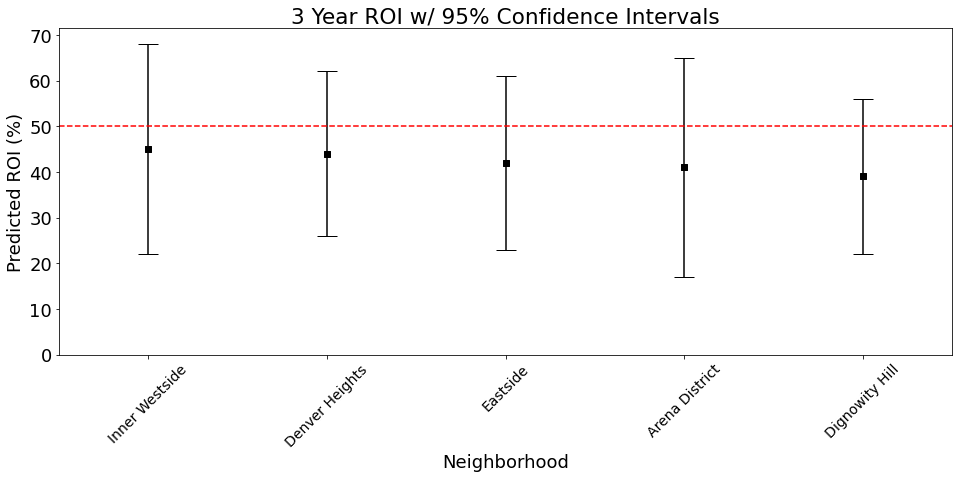

In [85]:
# Barplot of our 3 year projected ROI for top zip codes
projection_barplot(top_zip_projections, years=3, save_fig=True)

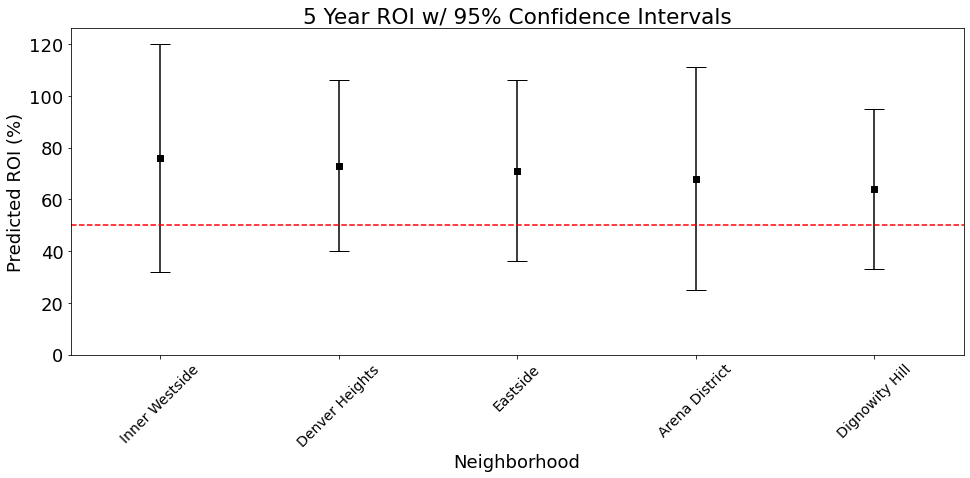

In [86]:
# Barplot of our 5 year projected ROI for our top zip codes
top_5year_projections = five_year_projections.sort_values('Predicted ROI (%)')[0:5].sort_values('Predicted ROI (%)',
                                                                                                ascending=False)
# Plot 5 year projections barplot
projection_barplot(top_5year_projections, years=5, save_fig=True)

Our top zip codes have projected 5 year ROI of 64% to 76%! Now lets visualize the average sale prices or our top 5 zip codes over 22 years.

### Average Housing Prices of our Top 5 Zip Codes from 2000 - 2022

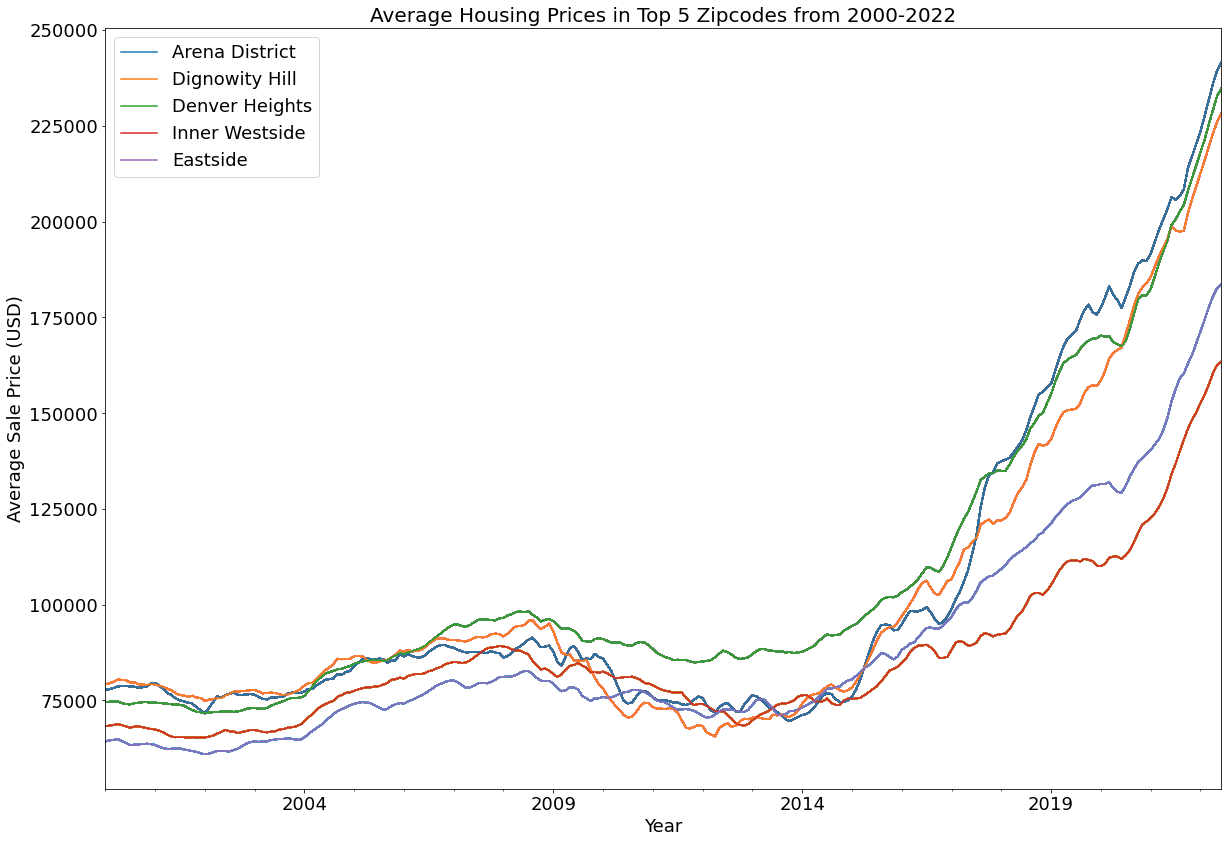

In [87]:
# Top 5 zip codes
top_5_zipcodes = [78203,78202,78210,78237,78220]

#plot the values grouped by zip code
plt.figure(figsize=(20,14))
for zipcode in model_df.RegionName.unique():
    for zipcode in top_5_zipcodes:
        model_df.loc[model_df['RegionName'] == zipcode].value.plot(label=zipcode)

plt.legend(labels=('Arena District','Dignowity Hill','Denver Heights',
                   'Inner Westside','Eastside'), loc='upper left')

plt.xlabel("Year", fontsize = 18)
plt.ylabel("Average Sale Price (USD)", fontsize=18)
plt.title('Average Housing Prices in Top 5 Zipcodes from 2000-2022', fontsize = 20)
# Save fig
plt.savefig('./images/top_5_over_time.jpeg')
plt.show();

We can see a similiar trend among all of our top 5 zip codes, although a bit more pronounced in the Arena District, Dignowity Hill, and Denver Heights.  This is likely due to the gentrification that has been taking place in these neighborhoods over the past several years and becoming desirable hotspots.  Unfortunately,  the crime rate is high in all of these neighborhoods and the schools all have below average ratings. It will likely take the schools several years to improve with the transition. 

### Map Visualization of Top 5 Zip Codes

In [88]:
#Import
import folium

#Create map
this_map = folium.Map(location = [29.5, -98.5])

# Add markers for zip codes 
folium.Marker(location=[29.4151, -98.4605], tooltip = 'Arena District').add_to(this_map)
folium.Marker(location=[29.4278, -98.4615], tooltip = 'Dignowity Hill').add_to(this_map)
folium.Marker(location=[29.3958, -98.4638], tooltip = 'Denver Heights').add_to(this_map)
folium.Marker(location=[29.4204, -98.5671], tooltip = 'Inner Westside').add_to(this_map)
folium.Marker(location=[29.4139, -98.3889], tooltip = 'Eastside').add_to(this_map)
 
#Set the zoom to fit our bounds
this_map.fit_bounds(this_map.get_bounds())

this_map

In [89]:
top_zip_projections

,Neighborhood,Zip Code,Investment Value ($),Predicted Sale Price ($),Min Pred Sale Price ($),Max Pred Sale Price ($),Predicted ROI (%),Min Pred ROI (%),Max Pred ROI (%),errors
6,Inner Westside,78237,163415.0,237227.36,199425.67,275029.05,45.0,22.0,68.0,23.0
5,Denver Heights,78210,234712.0,337287.14,295798.77,378775.51,44.0,26.0,61.0,18.0
9,Eastside,78220,183720.0,260936.10,226854.29,295017.91,42.0,23.0,61.0,19.0
0,Arena District,78203,241568.0,339839.66,283808.21,395871.11,41.0,17.0,64.0,24.0
1,Dignowity Hill,78202,228219.0,316210.20,277737.86,354682.55,39.0,22.0,55.0,17.0


## Recommendations

The top 5 zip codes ranked by highest return on investment (ROI) with the least amount of unpredictability and variation are:
* 78237: Inner Westside
* 78210: Denver Heights
* 78220: Eastside
* 78203: Arena District
* 78202: Dignowity Hill

These 5 zip codes boast projected returns on a 3 year investment ranging from 38% to 45%, and 5 year returns from 64% to 75%!  The entry price into these neighborhoods range from 163k to 241k, much lower than the average median price of the whole SA metro area at 348k.  Following are details and my recommendations for purchasing in each of these areas.

### Inner Westside

The Inner Westside has the lowest initial investment value at 163k and the highest projected 3 and 5 year ROI at 45% and 76%, respectively. Homes should be bought in the winter and sold in the summer for an additional 2% ROI.

### Denver Heights

Denver Heights has an initial investment value of 235k, which is the 2nd highest in our recommended zip codes.  It has a projected 3 year ROI of 44% and 5 year ROI at 73%. It has become a millennial hot spot with a median age of 27 due to its close proximity to downtown and is already in the process of becoming an up and coming neighborhood.  It has low variation in the median sale price month over month which makes one of our safest investments.

### Eastside

The Eastside has an initial investment value of 184k, making it the 2nd lowest on our list.  It has a 3 year projected ROI of 42%, while its 5 year projected ROI is 71%.  It also has low variation in the data making it a safe investment.  This area offers opportunities to purchase larger plots of land, as this area was mostly used for agricultural purposes up until recently, as the demand has increased from people wanting more land and privacy.

### Arena District

The Arena District surrounds the AT&T Center where the Spurs play, and is loaded with bars, coffee shops, restaurants, and parks.  This has been another rising millennial hot spot over the last several years. It is projected to have a 3 and 5 year ROI of 41% and 68%, respectively.  The initial investment will cost 242k, which is the highest of our recommended zip codes.  It also has largest errors in its predictions, making it our riskiest investment, relatively speaking.  Interestingly enough, homes should be purchased in the winter and sold in the summer which does not follow the normal trends that we typically see.  This strategy will add an additional 2% ROI when buying and selling in the Arena District.  

### Dignowity Hill

Dignowity Hill was the first residential suburb in San Antonio and is now a historic zone.  The area now offers parks, restaurants, historic buildings, and renovated high end estates making it a place for everyone.  It has an initial investment value of 228k, and projected 3 and 5 year ROI of 39% and 64%, respectively.  Homes should be purchased in the winter and sold in the summer for an additional gain of 1% ROI.  There is the smallest error in our predictions for this zip code, making this our safest investment.

As stated before, all of the home prices in these areas are significantly lower than the median home price of the San Antonio area. It should be noted that there is a caveat to these low prices, the schools are below average in every one of these zip codes and the rate of crime is high.  This is typical in big cities, and the schools typically improve as time goes on in neighborhoods with increasing home value.  If any of these factors are a concern, I recommend taking a look at the other zip codes that were in our top 10 ROI.  These other zip codes are in more desirable suburban areas that have good schools, but also come at a much higher entry point and more risk associated with the purchase. 

## Future Work

Our model only looked at factors endogenous to the time series data.  While this is useful for understanding how real estate markets change over time, it does nothing to explain all the other factors that are driving changes in housing prices. Some next steps in this project include added exogenous factors to our model:
* Interest rates
* Crime data
* Median income over time

I would also like to explore other areas in the dataset and modeling packages such as Facebook Prophet.